# Telecommunication_user_churn_classifier


## 1. Data Mining


In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
print("Libraries imported successfully.....")
#Importing data
df = pd.read_csv("telecom_customer_churn.csv")

#print("Data imported successfully.....")


Libraries imported successfully.....


In [2]:
# Remove the columns "Customer Status", "Churn Category", and "Churn Reason"
columns_to_remove = ["Customer Status", "Churn Category", "Churn Reason"]
df_train = df.drop(columns=columns_to_remove)

# Take out 30% of the DataFrame as the test set
test_size = 0.3
df_test = df_train.sample(frac=test_size, random_state=42)
df = df.drop(index=df_test.index)


## 2. Data Cleaning and EDA


In [3]:
#Separate numerical and categorical columns

from preprolib import myfunctions
num_cols = []
cat_cols = []

ignore_list = ['Zip Code', 'Longitude', 'Latitude', 
                'Customer ID', 'Churn Category', 
                'Churn Reason', 'Customer Status', 'City']

myfunctions.cat_or_num(df, ignore_list, num_cols, cat_cols)

label = 'Customer Status'


## 2.1 Exploratory Data Analysis
### 2.1.1 Numerical data


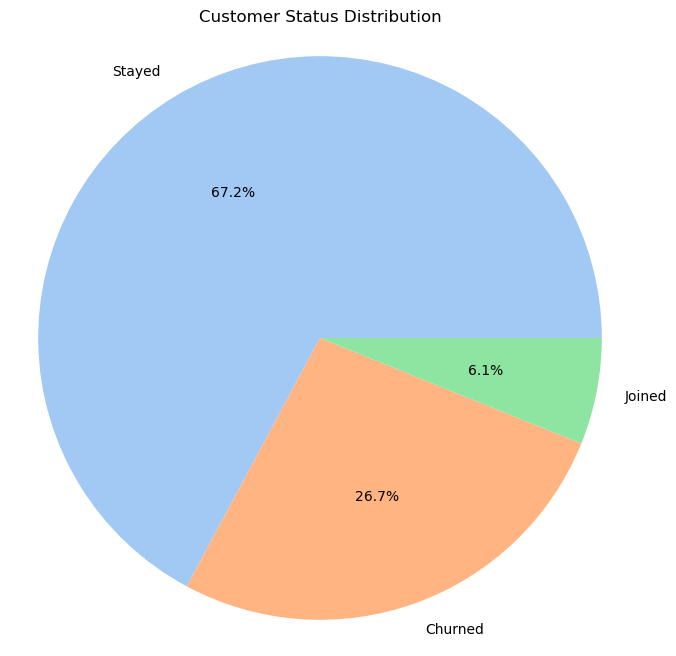

In [4]:
# Calculate the value counts for each 'Customer Status'
Customer_status_counts = df['Customer Status'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(Customer_status_counts, labels=Customer_status_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title("Customer Status Distribution")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


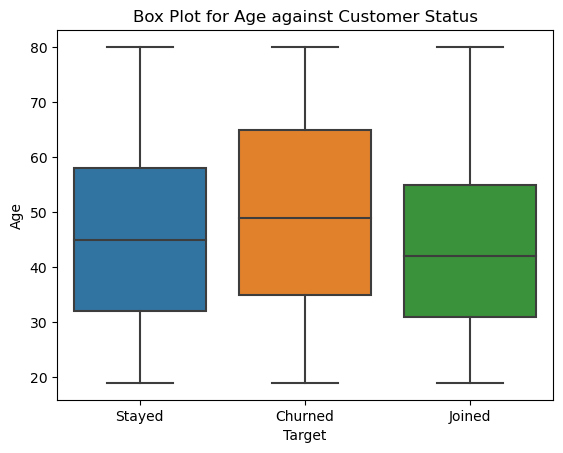

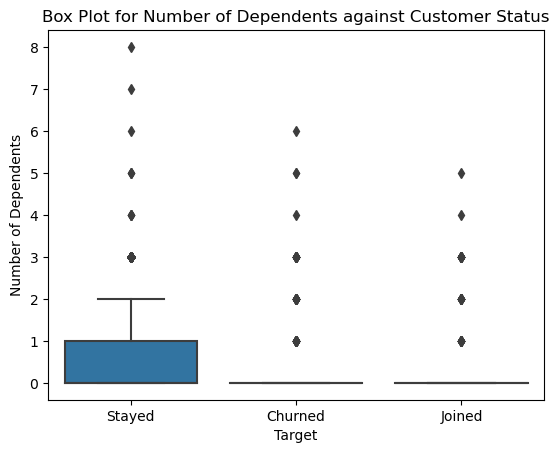

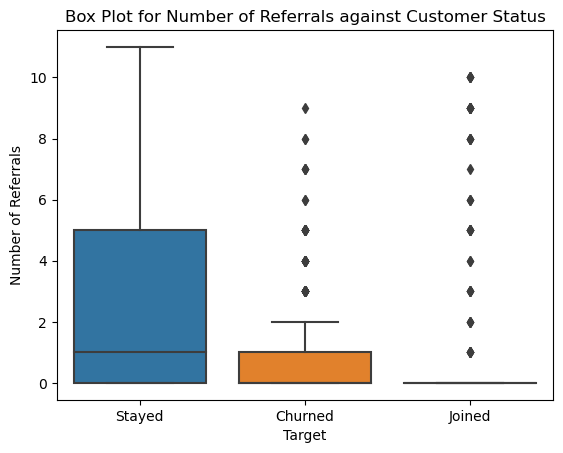

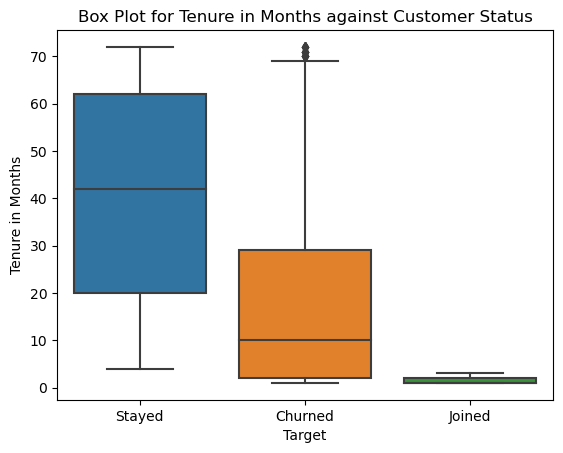

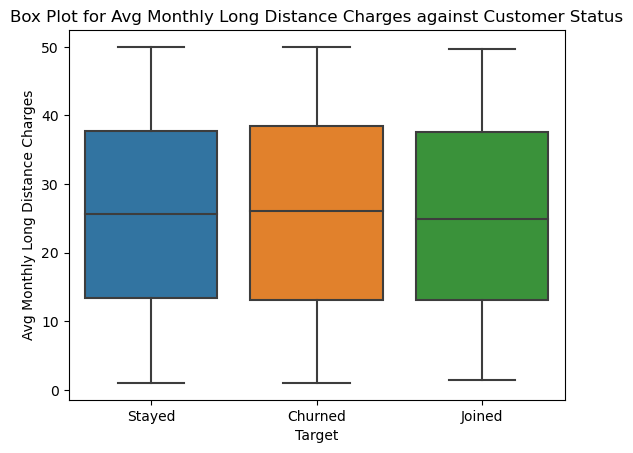

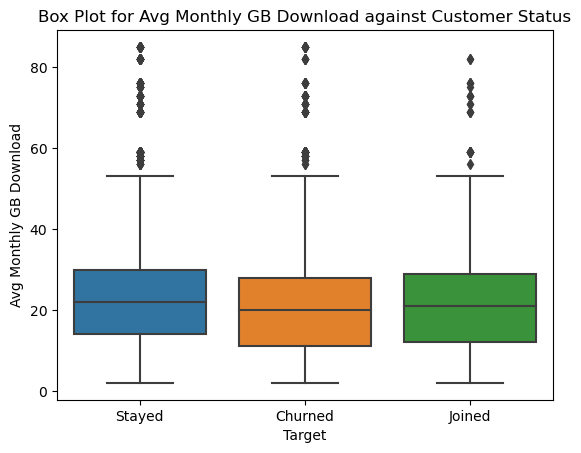

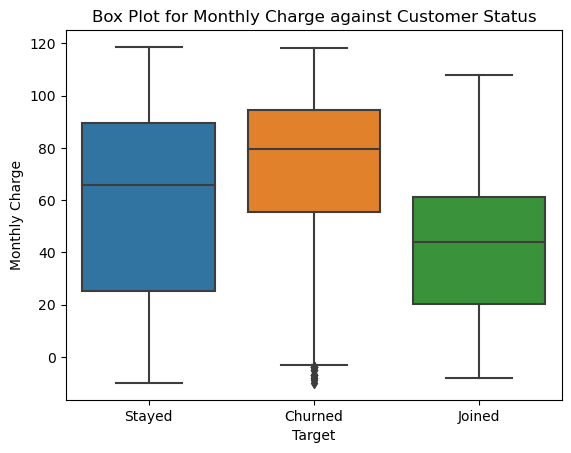

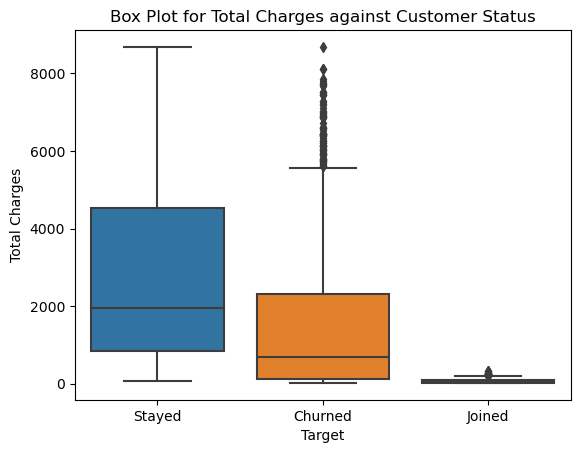

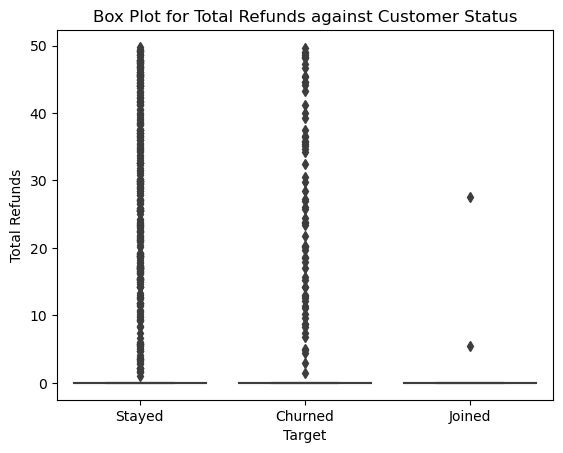

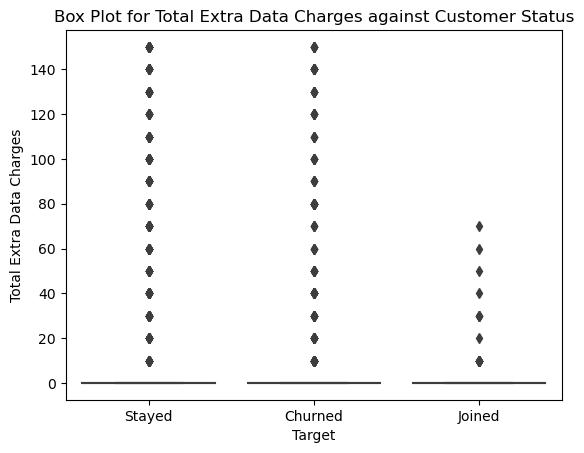

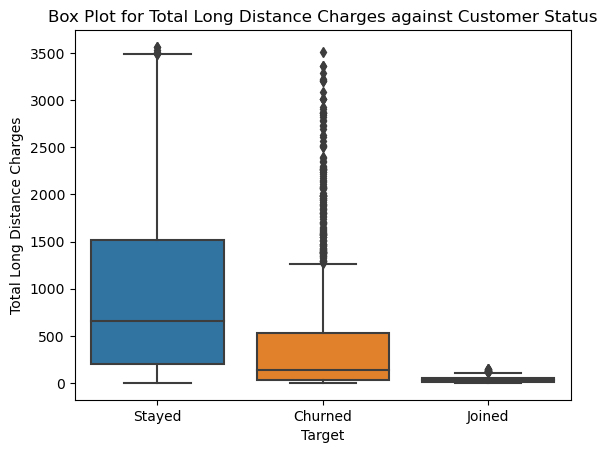

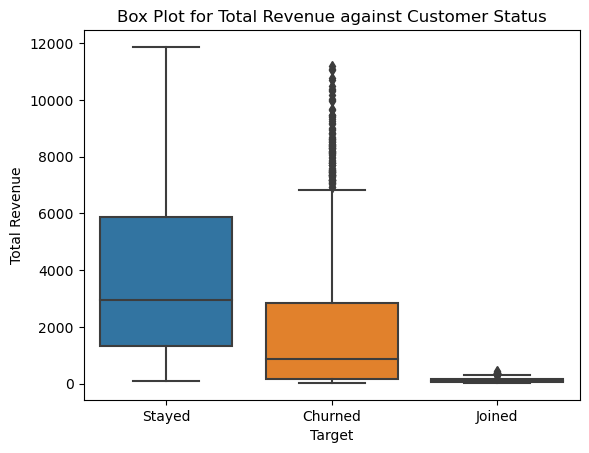

['Age',
 'Number of Dependents',
 'Number of Referrals',
 'Tenure in Months',
 'Avg Monthly Long Distance Charges',
 'Avg Monthly GB Download',
 'Monthly Charge',
 'Total Charges',
 'Total Refunds',
 'Total Extra Data Charges',
 'Total Long Distance Charges',
 'Total Revenue']

In [5]:
# Box plots for numerical data
for column in num_cols:
    plt.figure()  # Create a new figure for each box plot
    sns.boxplot(x='Customer Status', y=column, data=df)
    plt.title(f'Box Plot for {column} against {"Customer Status"}')
    plt.ylabel(column)
    plt.xlabel('Target')
    plt.show()

num_cols


Inferences notes in readme
### 2.1.2 Categorical data

  



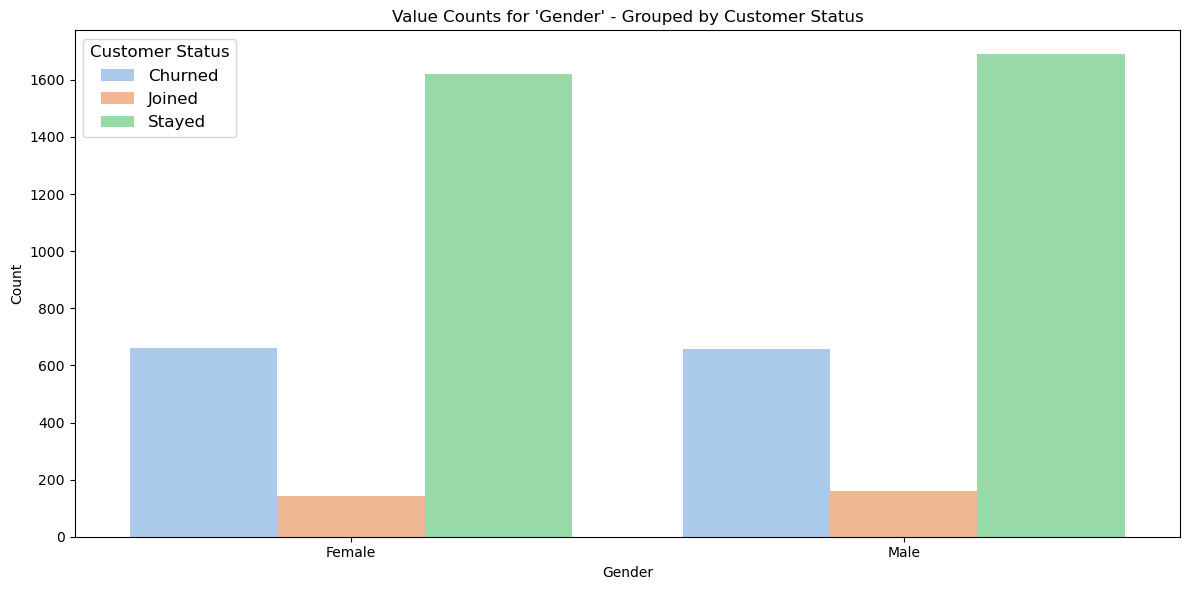

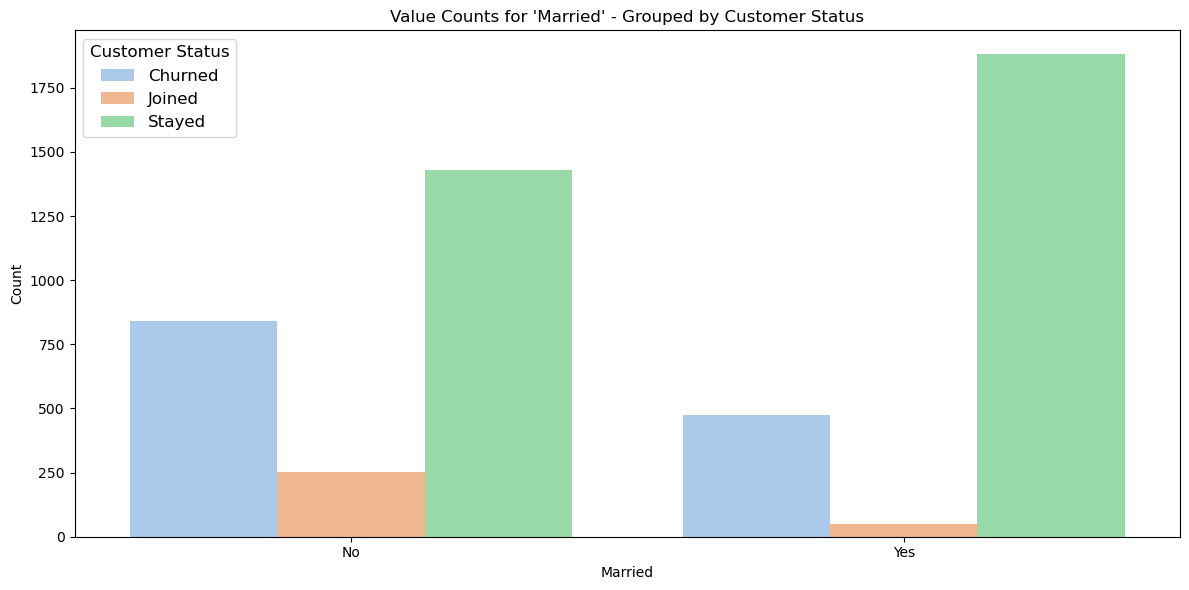

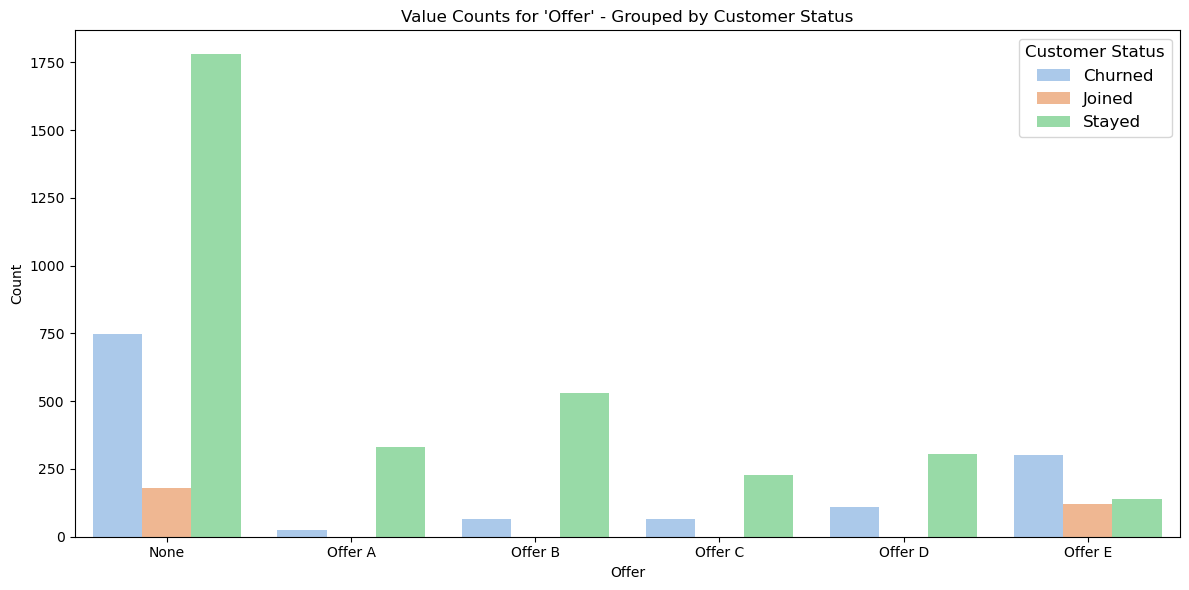

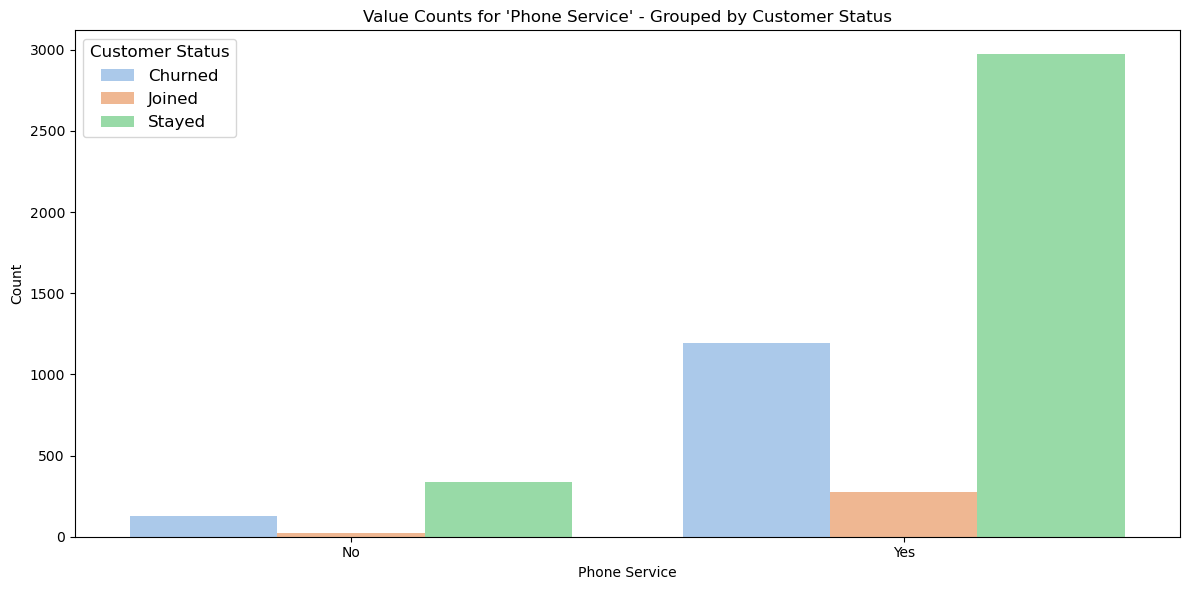

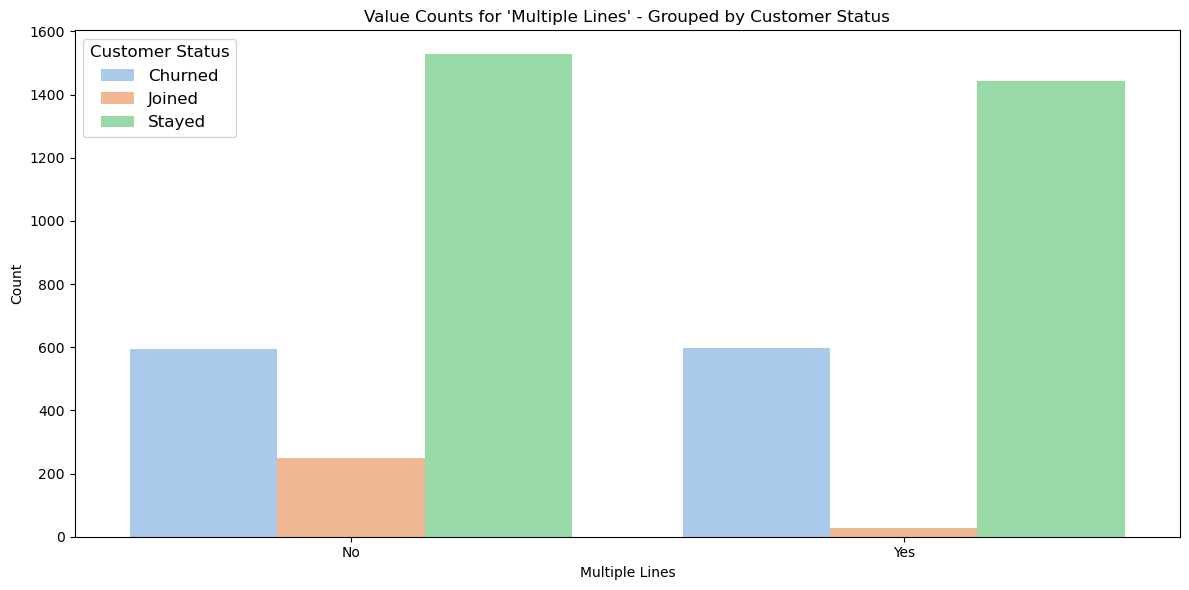

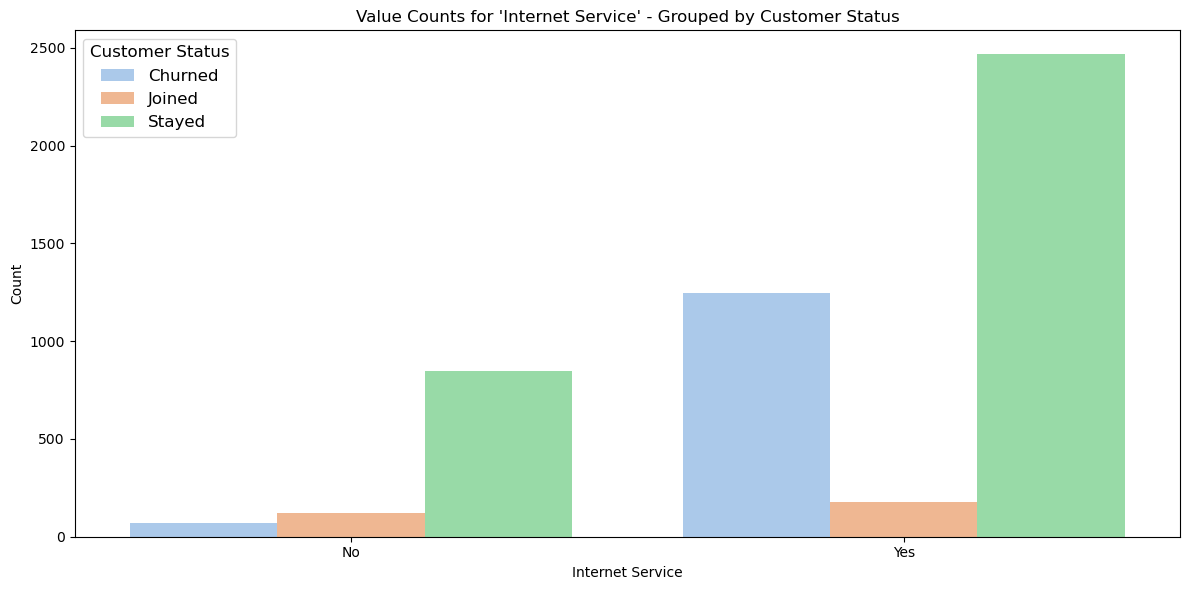

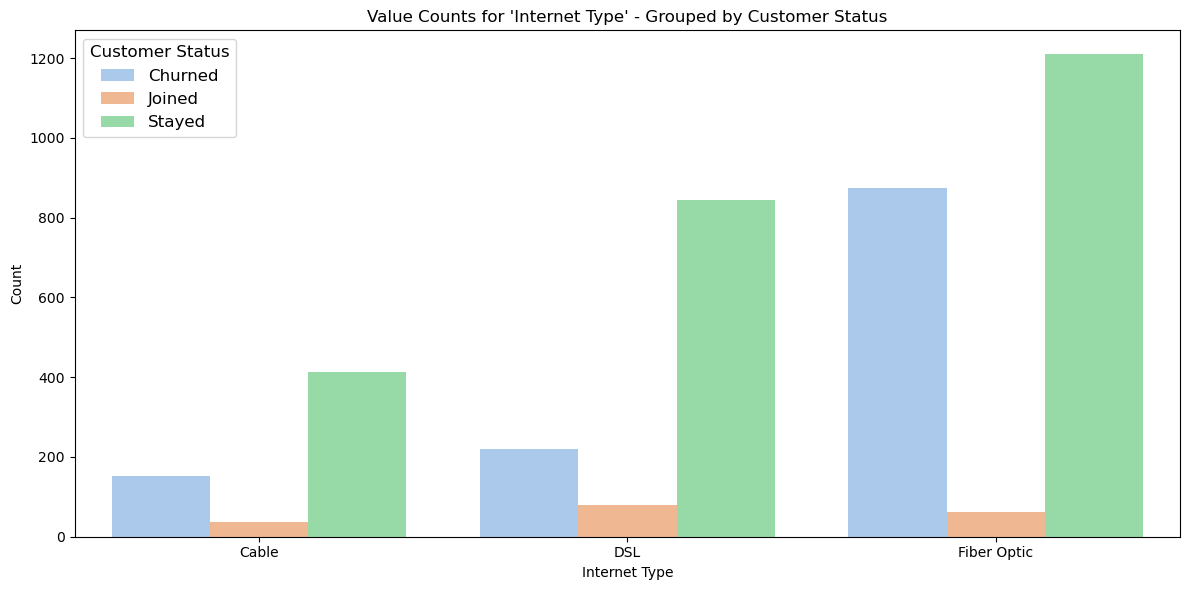

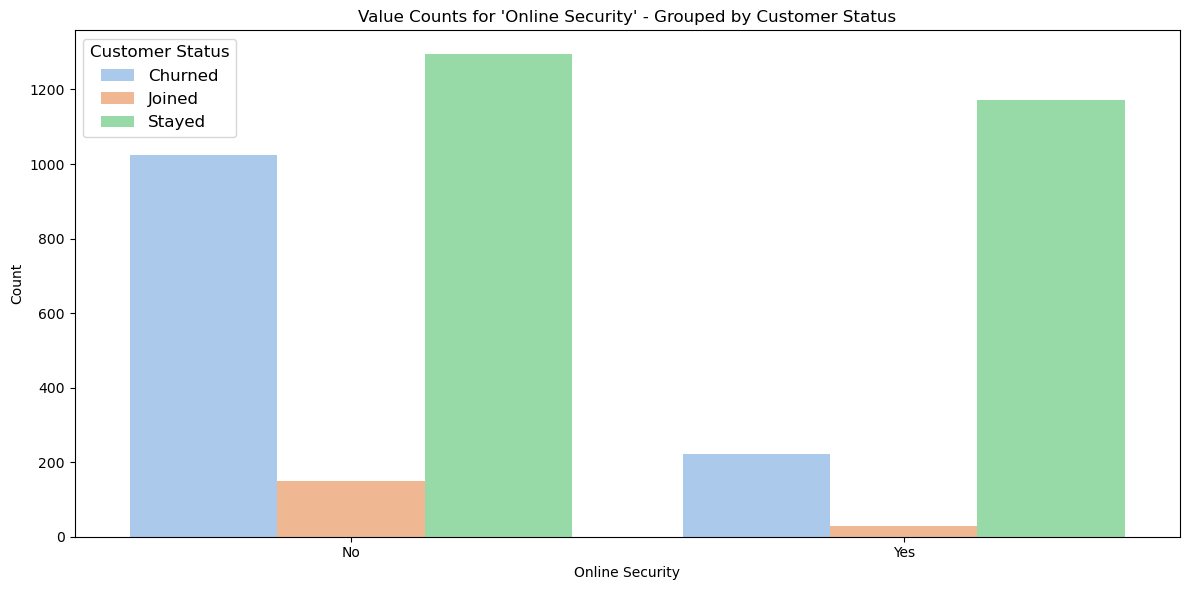

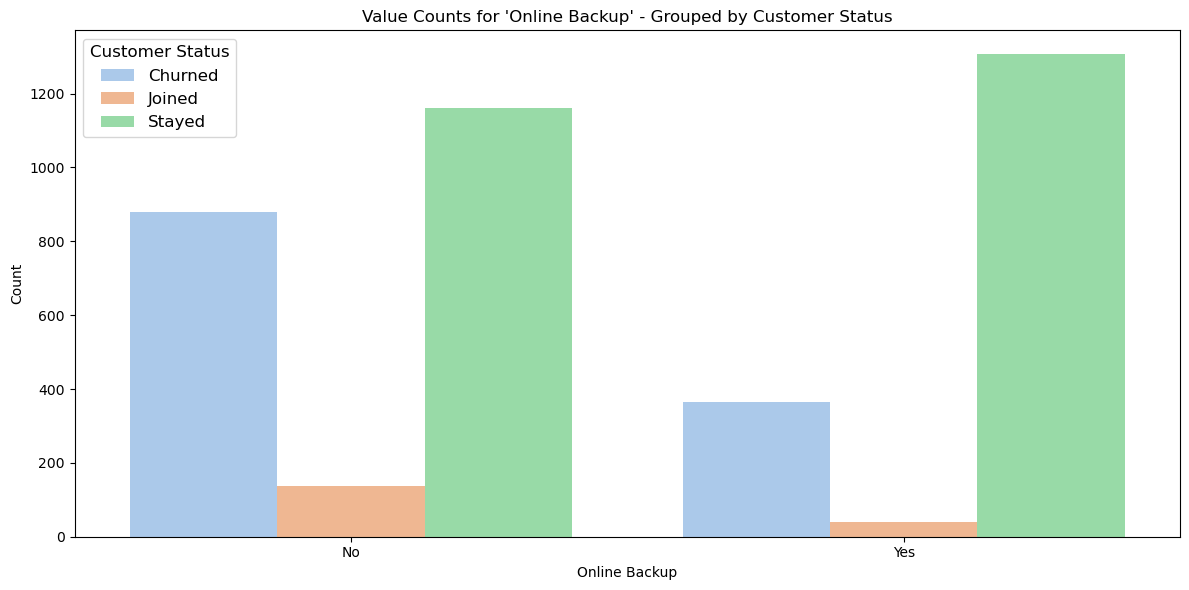

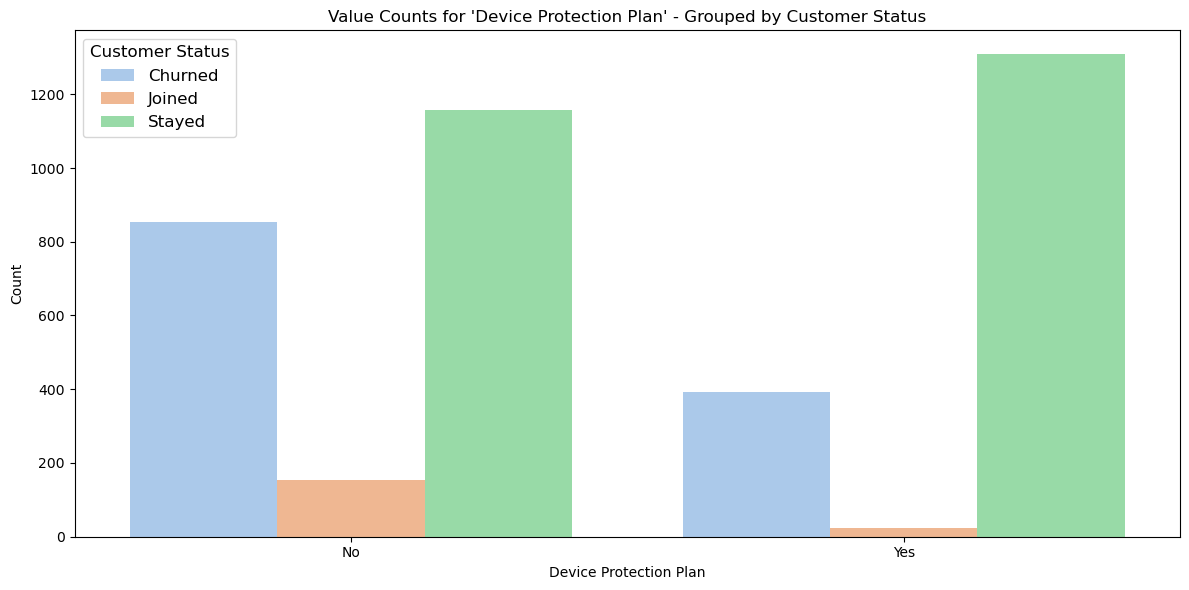

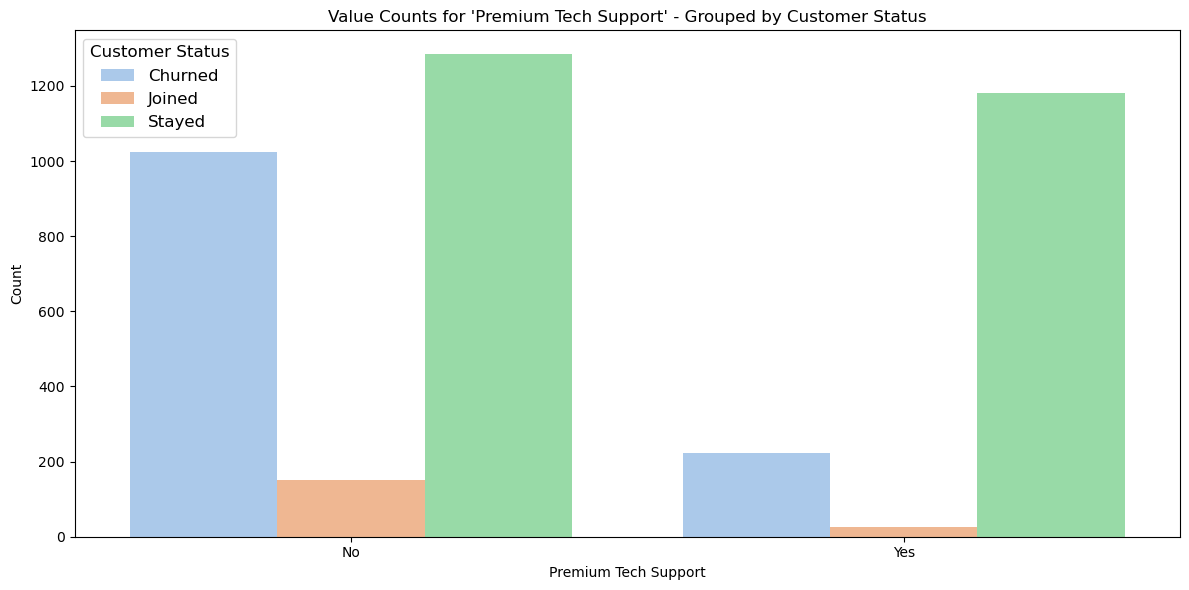

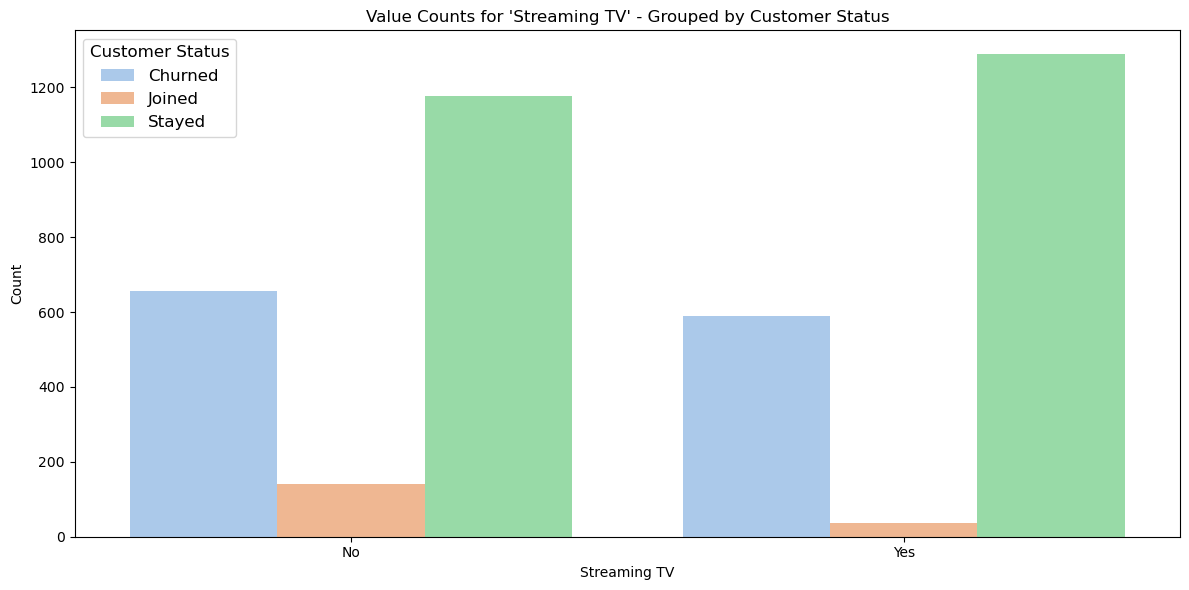

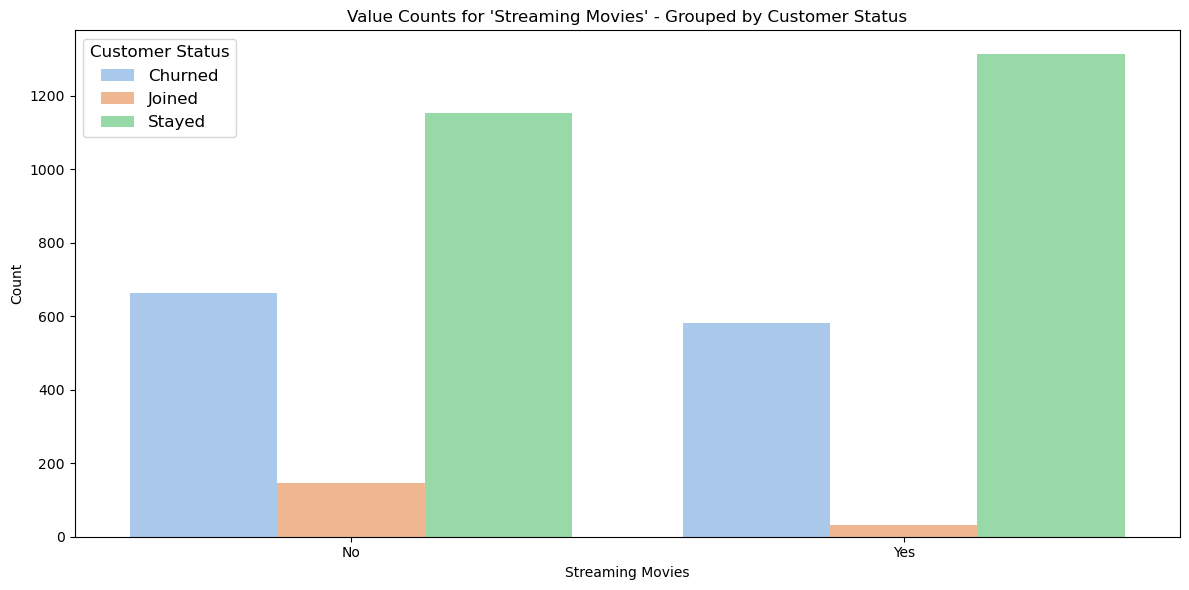

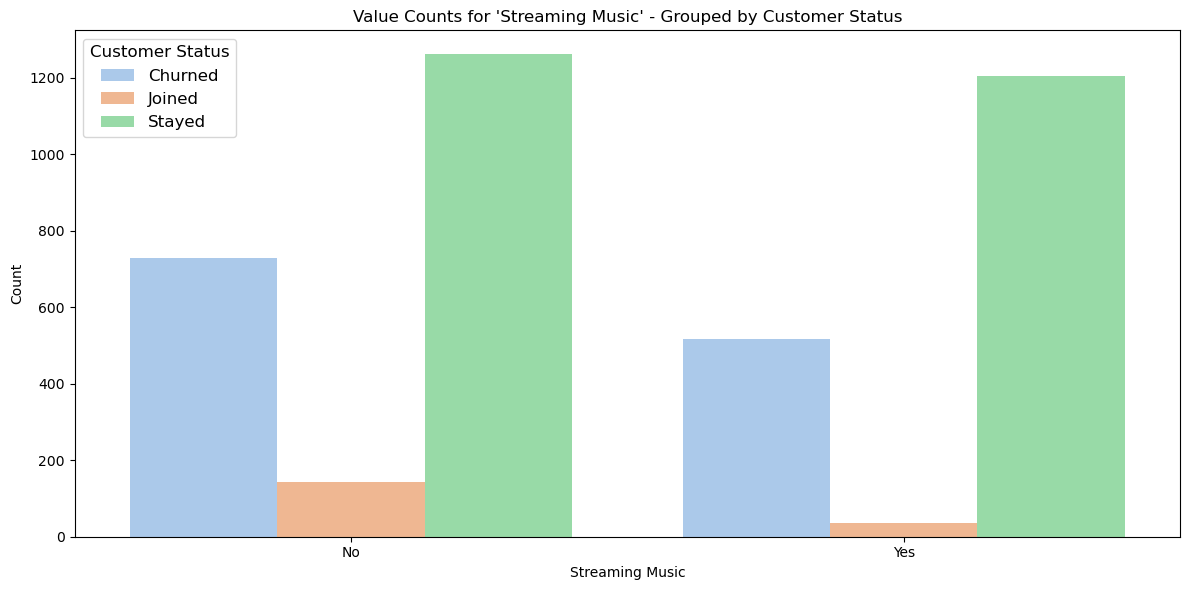

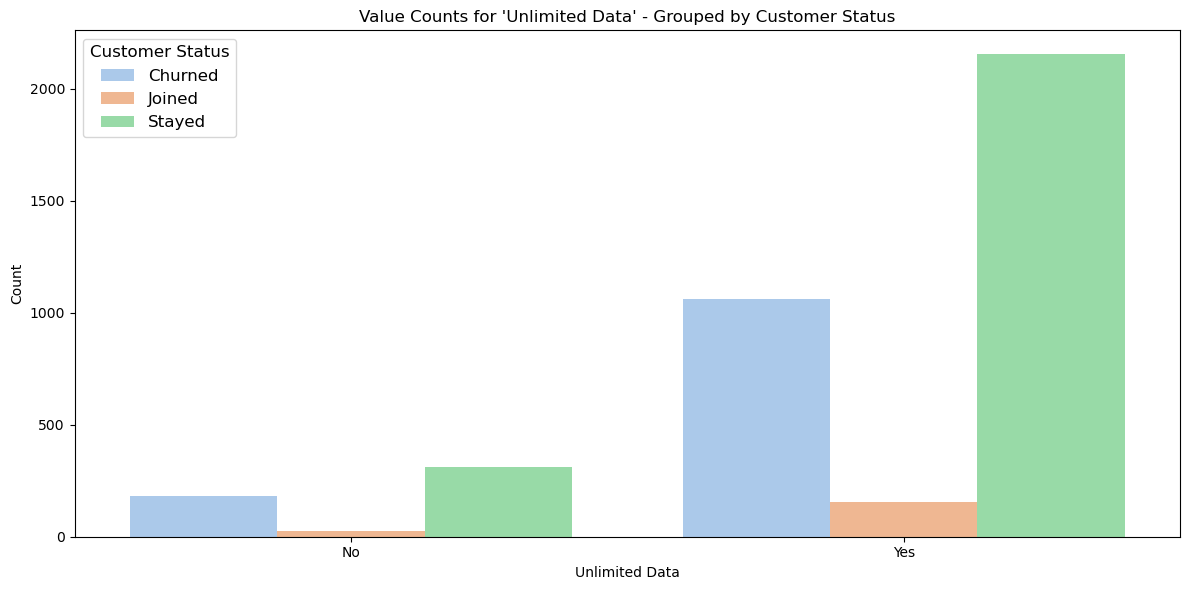

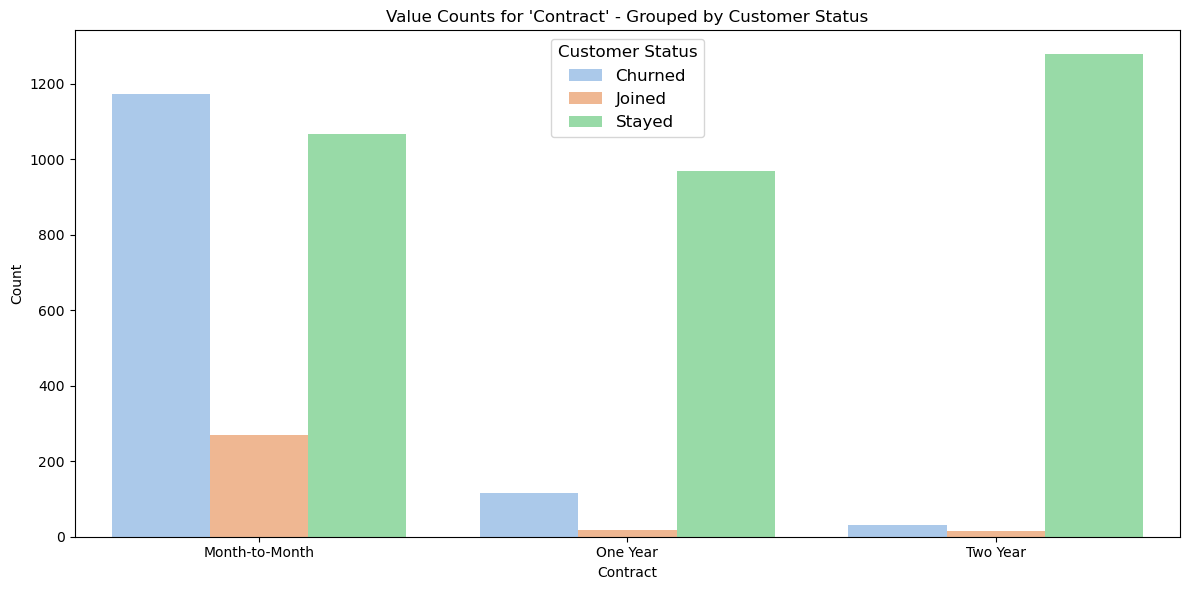

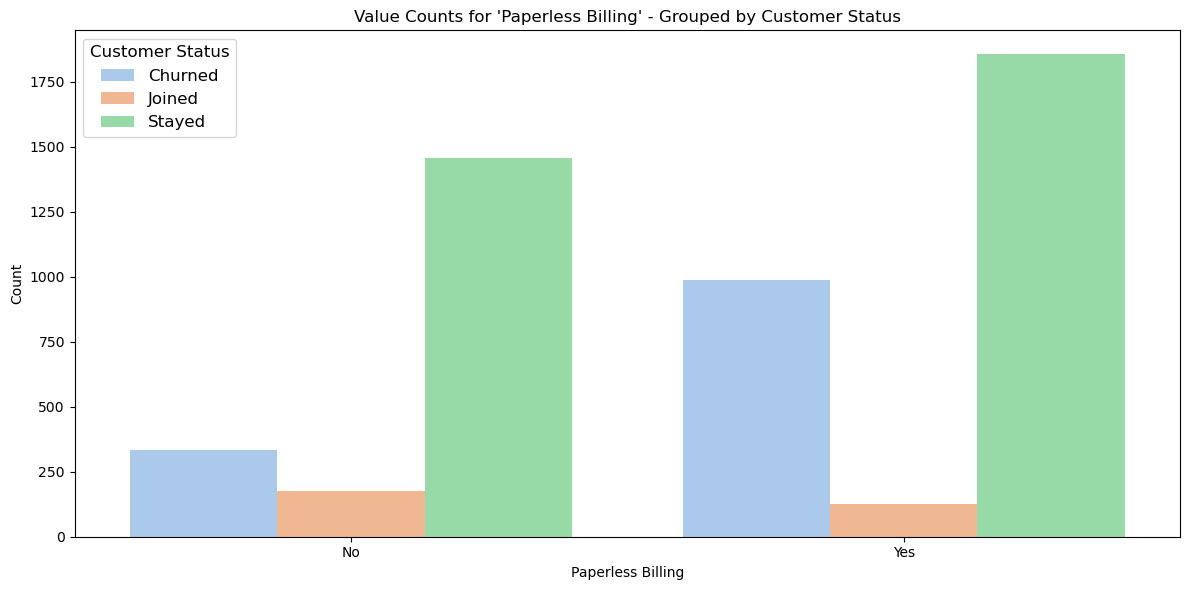

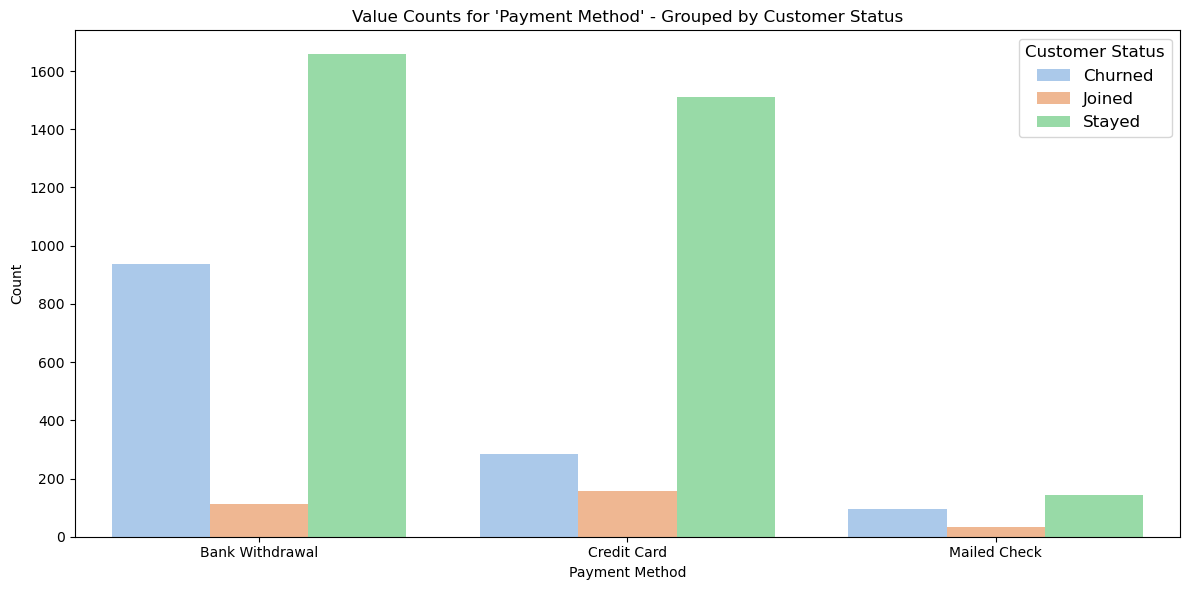

In [6]:
# Group by 'Customer Status' and each categorical column, and get value counts for each category
for col in cat_cols:
    plt.figure(figsize=(12, 6))
    plt.title(f"Value Counts for '{col}' - Grouped by Customer Status")

    # Group the data by 'Customer Status' and the current column, and get value counts for each category
    group_counts = df.groupby(['Customer Status', col]).size().unstack()

    # Plot the grouped bar chart
    sns.barplot(data=group_counts.reset_index().melt(id_vars='Customer Status', value_name='Count'),
                x=col, y='Count', hue='Customer Status', palette='pastel')

    # Set labels and legend
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Customer Status', title_fontsize='large', fontsize='large')

    plt.tight_layout()
    plt.show()
    


### 2.2 Data preprocessing


In [7]:
##num_cols.remove

remove_num = ['Age', 'Avg Monthly Long Distance Charges',  'Avg Monthly GB Download', 'Monthly Charge']

num_cols = [x for x in num_cols if x not in remove_num]


##cat_cols.remove

remove_cat = ['Gender', 'Married'  'Multiple Lines']

cat_cols = [x for x in cat_cols if x not in remove_cat]


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Define the features and label
features = cat_cols + num_cols
label = 'Customer Status'

# Convert the label column to ordinal categories
label_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
y = label_encoder.fit_transform(df[label].values.reshape(-1, 1))

# Function to encode based on the percentage of churn per category
def custom_encode(column, churn_column):
    churn_percentage = df.groupby(column)[churn_column].mean()
    return churn_percentage.rank().fillna(0).astype(int)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], y, test_size=0.3, random_state=0)

# Define a pipeline for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define a pipeline for categorical columns
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Create a ColumnTransformer to apply the pipeline to the numeric and categorical columns
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# Fit the preprocessor to the training data and transform both the training and test data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print('Training Set: %d, Test Set: %d \n' % (len(X_train), len(X_test)))

# Print the transformed DataFrames
print("X_train_Transformed:\n", X_train_transformed)
print("\nX_test_Transformed:\n", X_test_transformed)


# Create a dictionary to map encoded variables to original labels
label_mapping = {}
for i, label in enumerate(label_encoder.categories_[0]):
    label_mapping[i] = label

# Print the dictionary
print("Encoded to Original Label Mapping:")
print(label_mapping)


Training Set: 3451, Test Set: 1479 

X_train_Transformed:
 [[-0.48082285 -0.65453894 -1.28106541 ...  2.          1.
   0.        ]
 [-0.48082285  1.65948084  1.1052522  ...  2.          0.
   0.        ]
 [ 2.75371838 -0.65453894 -1.28106541 ...  0.          0.
   0.        ]
 ...
 [-0.48082285 -0.65453894 -1.24061935 ...  0.          0.
   0.        ]
 [ 1.67553797 -0.32396469 -0.14857569 ...  0.          1.
   1.        ]
 [ 2.75371838 -0.65453894 -0.91705086 ...  0.          0.
   1.        ]]

X_test_Transformed:
 [[-0.48082285 -0.65453894 -1.28106541 ...  0.          1.
   0.        ]
 [-0.48082285 -0.65453894  1.30748251 ...  2.          0.
   0.        ]
 [-0.48082285 -0.32396469 -0.31035994 ...  0.          1.
   0.        ]
 ...
 [-0.48082285  0.99833233  1.30748251 ...  2.          0.
   1.        ]
 [-0.48082285 -0.65453894 -0.02723751 ...  0.          1.
   1.        ]
 [-0.48082285 -0.65453894  1.42882069 ...  2.          0.
   1.        ]]
Encoded to Original Label Mappi

In [9]:
features

['Married',
 'Offer',
 'Phone Service',
 'Multiple Lines',
 'Internet Service',
 'Internet Type',
 'Online Security',
 'Online Backup',
 'Device Protection Plan',
 'Premium Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Streaming Music',
 'Unlimited Data',
 'Contract',
 'Paperless Billing',
 'Payment Method',
 'Number of Dependents',
 'Number of Referrals',
 'Tenure in Months',
 'Total Charges',
 'Total Refunds',
 'Total Extra Data Charges',
 'Total Long Distance Charges',
 'Total Revenue']

## 3. Model Selection


In [10]:
#Import classifier
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier().fit(X_train_transformed, y_train)  # Convert one-hot encoded y_train to 1D array


#Model evaluation
#from preprolib.myfunctions import evaluate_model

#evaluate_model(rf_model,X_test_transformed, y_test)



C:\Users\User\AppData\Local\Temp\ipykernel_3728\1786165363.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model = RandomForestClassifier().fit(X_train_transformed, y_train)  # Convert one-hot encoded y_train to 1D array


In [11]:
def evaluate_model(curr_model, X_test, y_test):
    import pandas as pd
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    #Convert the one-hot encoded y_test to a 1-dimensional array
    y_test = y_test

    predictions = curr_model.predict(X_test)


    #Calculate the necessary metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    #Print the results for the current model
    print("Model Evaluation:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

evaluate_model(rf_model,X_test_transformed, y_test)


Model Evaluation:
Accuracy: 0.8323191345503719
Precision: 0.8273756347717985
Recall: 0.8323191345503719
F1-score: 0.8263798630584416


In [12]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with 5 folds (you can adjust the number of folds as needed)

cv_scores = cross_val_score(rf_model, X_train_transformed, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation Scores:", cv_scores)
print("Average Cross-validation Accuracy:", cv_scores.mean())


c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConvers

Cross-validation Scores: [0.83791606 0.83768116 0.81014493 0.80434783 0.83188406]
Average Cross-validation Accuracy: 0.824394806938065


In [13]:
import joblib

# Save the model to a file
joblib.dump(rf_model, 'trained_rf_model.pkl')

print("Model saved successfully.")



Model saved successfully.


In [14]:
# Load the model from the file
loaded_rf_model = joblib.load('trained_rf_model.pkl')

# Transform the test data using the preprocessor
df_test_transformed = preprocessor.transform(df_test)

# Make predictions on the test data using the loaded model
test_pred = loaded_rf_model.predict(df_test_transformed)

# Reshape the test_pred array to a 2D array
test_pred_2d = test_pred.reshape(-1, 1)

# Map the predicted values back to their original labels
predicted_labels = label_encoder.inverse_transform(test_pred_2d)

# Print the predicted labels
print("Predicted Labels:")
print(predicted_labels)



Predicted Labels:
[['Stayed']
 ['Stayed']
 ['Stayed']
 ...
 ['Stayed']
 ['Churned']
 ['Stayed']]


In [15]:
# Create a new DataFrame with the predicted labels
predicted_df = pd.DataFrame(predicted_labels, columns=['Predicted_Customer_Status'])

# Concatenate the predicted_df with df_test
df_test_with_predictions = pd.concat([df_test, predicted_df], axis=1)

# Print the DataFrame with the predicted labels
print(df_test_with_predictions)


     Customer ID  Gender   Age Married  Number of Dependents           City  \
185   0301-KOBTQ    Male  50.0      No                   0.0       Capitola   
2715  3865-YIOTT    Male  40.0     Yes                   1.0  San Francisco   
3825  5377-NDTOU  Female  26.0     Yes                   0.0      San Pedro   
1807  2637-FKFSY  Female  61.0     Yes                   0.0          Wasco   
132   0224-NIJLP    Male  30.0     Yes                   3.0        Turlock   
...          ...     ...   ...     ...                   ...            ...   
2105         NaN     NaN   NaN     NaN                   NaN            NaN   
2106         NaN     NaN   NaN     NaN                   NaN            NaN   
2108         NaN     NaN   NaN     NaN                   NaN            NaN   
2109         NaN     NaN   NaN     NaN                   NaN            NaN   
2111         NaN     NaN   NaN     NaN                   NaN            NaN   

      Zip Code   Latitude   Longitude  Number of Re

# Churn Reason Anaysis

In [16]:
df_reason = df[df['Customer Status'] == 'Churned']
df_reason 


,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.90,280.85,0.0,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.00,1237.85,0.0,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.90,267.40,0.0,0,22.14,289.54,Churned,Dissatisfaction,Network reliability
18,0022-TCJCI,Male,79,No,0,Daly City,94015,37.680844,-122.481310,0,...,Credit Card,62.70,2791.50,0.0,0,480.15,3271.65,Churned,Dissatisfaction,Limited range of services
21,0023-XUOPT,Female,26,Yes,0,Carnelian Bay,96140,39.227434,-120.091806,1,...,Bank Withdrawal,94.10,1215.60,0.0,0,566.28,1781.88,Churned,Other,Don't know
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6992,9921-ZVRHG,Female,44,No,0,Traver,93673,36.456091,-119.486225,0,...,Bank Withdrawal,80.45,1072.00,0.0,0,16.66,1088.66,Churned,Competitor,Competitor had better devices
7007,9940-RHLFB,Female,53,No,0,Sunset Beach,90742,33.719221,-118.073596,0,...,Bank Withdrawal,75.30,75.30,0.0,0,26.06,101.36,Churned,Competitor,Competitor made better offer
7012,9947-OTFQU,Male,65,No,0,Covina,91722,34.097345,-117.906736,0,...,Bank Withdrawal,74.40,1074.30,0.0,0,436.65,1510.95,Churned,Competitor,Competitor had better devices
7020,9961-JBNMK,Male,79,No,0,Desert Center,92239,33.889605,-115.257009,0,...,Bank Withdrawal,-1.00,2030.30,10.2,0,887.67,2907.77,Churned,Dissatisfaction,Product dissatisfaction


In [17]:
#Separate numerical and categorical columns

num_cols_res = []
cat_cols_res = []

ignore_list = ['Zip Code', 'Longitude', 'Latitude', 
                'Customer ID', 'Churn Category', 
                'Churn Reason', 'Customer Status', 'City']

myfunctions.cat_or_num(df_reason, ignore_list, num_cols_res, cat_cols_res)

label = 'Customer Status'


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

# Define the imputer
imputer = SimpleImputer(strategy='most_frequent')  # You can choose the strategy as per your requirement

# Define the column transformer
preprocessor = make_column_transformer((imputer, df_reason.columns))

# Fit and transform the DataFrame through the pipeline
df_transformed = preprocessor.fit_transform(df_reason)

# Convert the transformed array back to a DataFrame
df_transformed = pd.DataFrame(df_transformed, columns=df_reason.columns)

# Set the data types of the columns to match the original DataFrame
for col in df_reason.columns:
    df_transformed[col] = df_transformed[col].astype(df_reason[col].dtype)

# Display the transformed DataFrame
print(df_transformed)


     Customer ID  Gender  Age Married  Number of Dependents           City  \
0     0004-TLHLJ    Male   50      No                     0     Costa Mesa   
1     0011-IGKFF    Male   78     Yes                     0       Martinez   
2     0013-EXCHZ  Female   75     Yes                     0      Camarillo   
3     0022-TCJCI    Male   79      No                     0      Daly City   
4     0023-XUOPT  Female   26     Yes                     0  Carnelian Bay   
...          ...     ...  ...     ...                   ...            ...   
1313  9921-ZVRHG  Female   44      No                     0         Traver   
1314  9940-RHLFB  Female   53      No                     0   Sunset Beach   
1315  9947-OTFQU    Male   65      No                     0         Covina   
1316  9961-JBNMK    Male   79      No                     0  Desert Center   
1317  9992-RRAMN    Male   40     Yes                     0      Riverbank   

      Zip Code   Latitude   Longitude  Number of Referrals  ...

In [19]:
df_reason = df_transformed


In [20]:
# Check for null values in categorical columns
for col in cat_cols_res:
    null_count = df_reason[col].isnull().sum()
    print(f"Number of null values in '{col}': {null_count}")


Number of null values in 'Gender': 0
Number of null values in 'Married': 0
Number of null values in 'Offer': 0
Number of null values in 'Phone Service': 0
Number of null values in 'Multiple Lines': 0
Number of null values in 'Internet Service': 0
Number of null values in 'Internet Type': 0
Number of null values in 'Online Security': 0
Number of null values in 'Online Backup': 0
Number of null values in 'Device Protection Plan': 0
Number of null values in 'Premium Tech Support': 0
Number of null values in 'Streaming TV': 0
Number of null values in 'Streaming Movies': 0
Number of null values in 'Streaming Music': 0
Number of null values in 'Unlimited Data': 0
Number of null values in 'Contract': 0
Number of null values in 'Paperless Billing': 0
Number of null values in 'Payment Method': 0


In [21]:
# Check for null values in categorical columns
for col in num_cols_res:
    null_count = df_reason[col].isnull().sum()
    print(f"Number of null values in '{col}': {null_count}")


Number of null values in 'Age': 0
Number of null values in 'Number of Dependents': 0
Number of null values in 'Number of Referrals': 0
Number of null values in 'Tenure in Months': 0
Number of null values in 'Avg Monthly Long Distance Charges': 0
Number of null values in 'Avg Monthly GB Download': 0
Number of null values in 'Monthly Charge': 0
Number of null values in 'Total Charges': 0
Number of null values in 'Total Refunds': 0
Number of null values in 'Total Extra Data Charges': 0
Number of null values in 'Total Long Distance Charges': 0
Number of null values in 'Total Revenue': 0


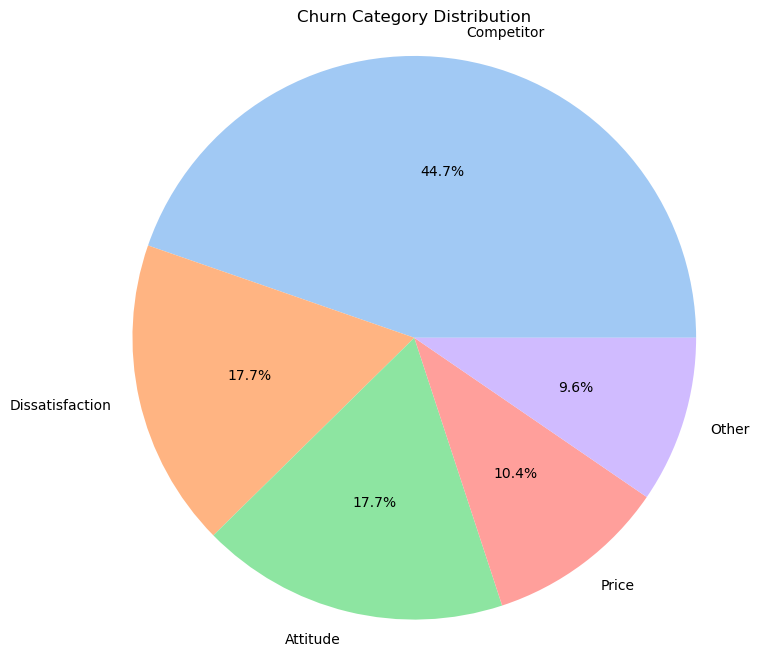

In [22]:
# Calculate the value counts for each 'Churn Category'
churn_category_counts = df_reason['Churn Category'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(churn_category_counts, labels=churn_category_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title("Churn Category Distribution")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


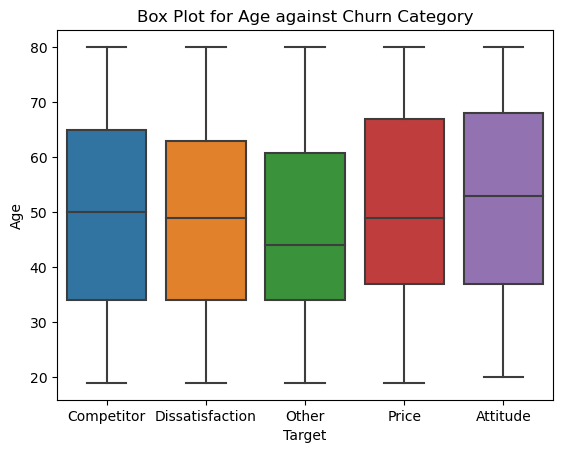

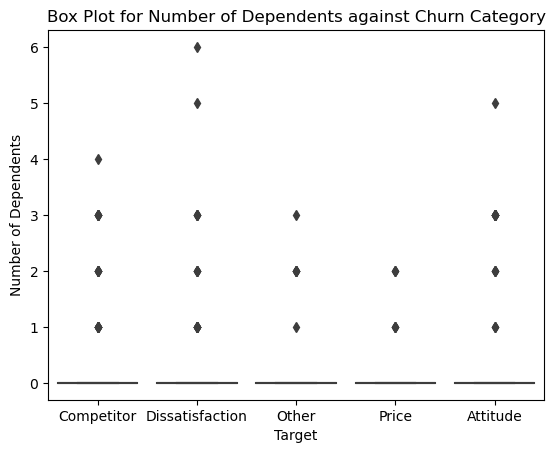

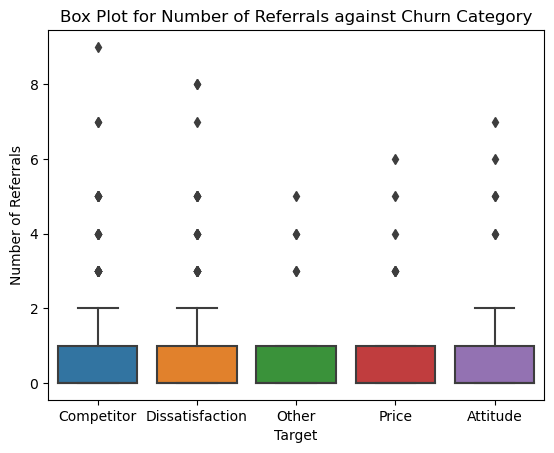

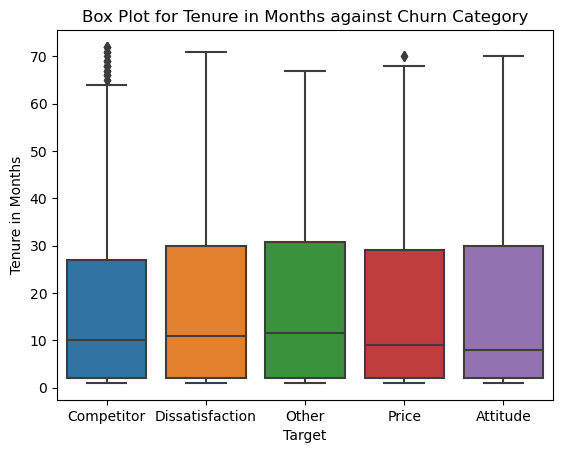

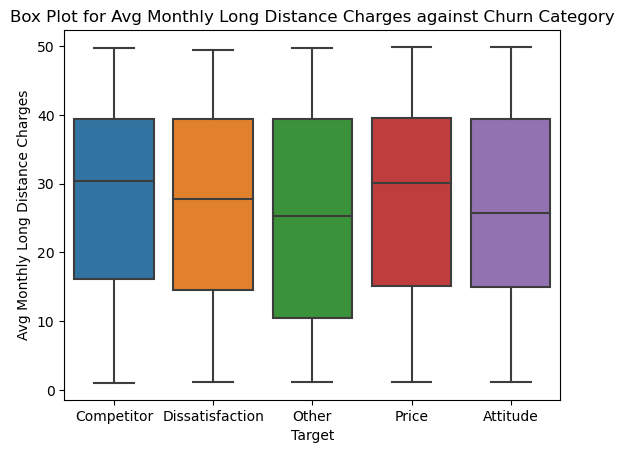

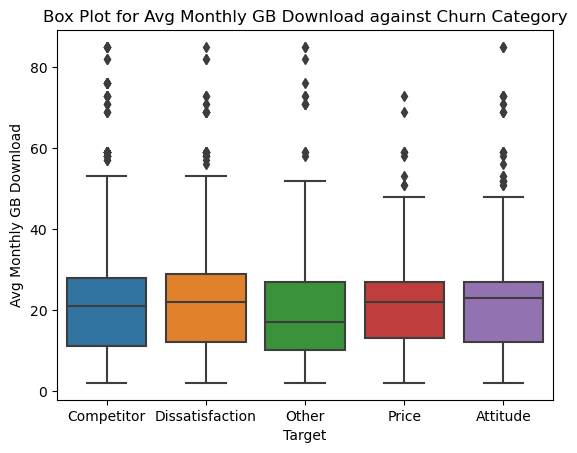

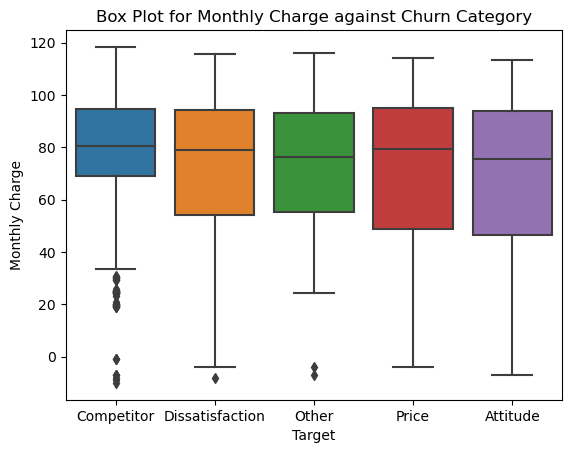

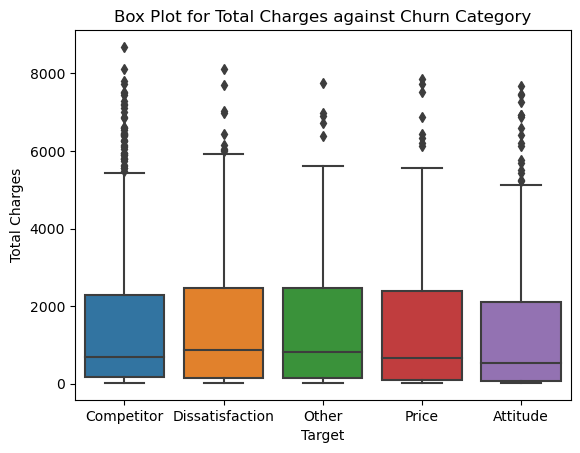

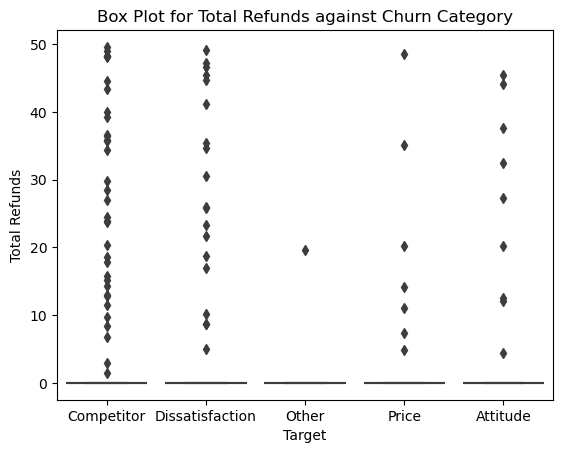

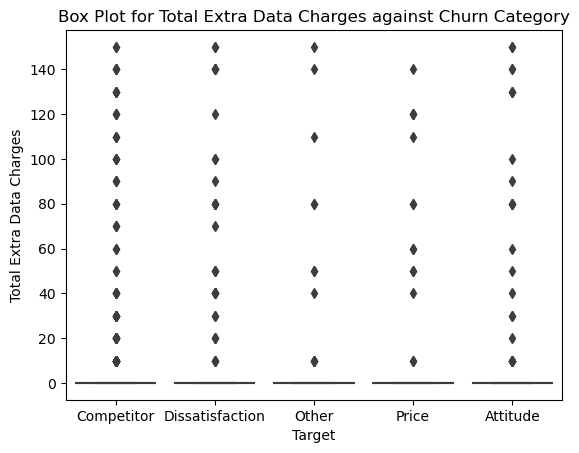

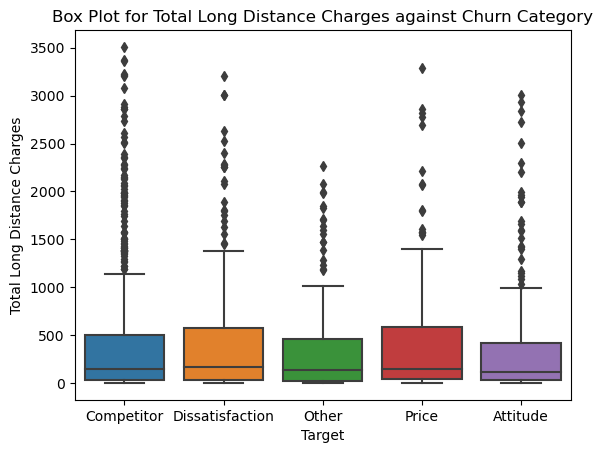

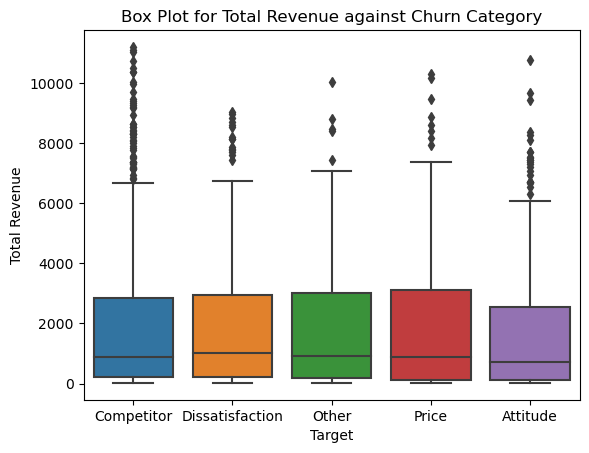

['Number of Dependents',
 'Number of Referrals',
 'Tenure in Months',
 'Total Charges',
 'Total Refunds',
 'Total Extra Data Charges',
 'Total Long Distance Charges',
 'Total Revenue']

In [23]:
# Box plots for numerical data
for column in num_cols_res:
    plt.figure()  # Create a new figure for each box plot
    sns.boxplot(x='Churn Category', y=column, data=df_reason)
    plt.title(f'Box Plot for {column} against {"Churn Category"}')
    plt.ylabel(column)
    plt.xlabel('Target')
    plt.show()

num_cols

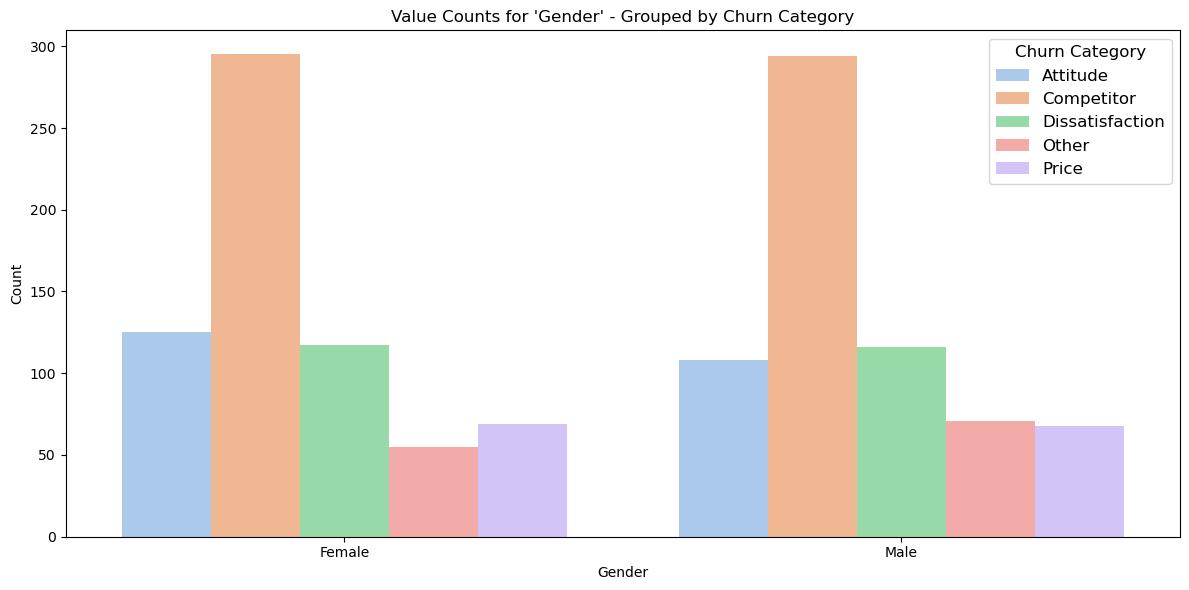

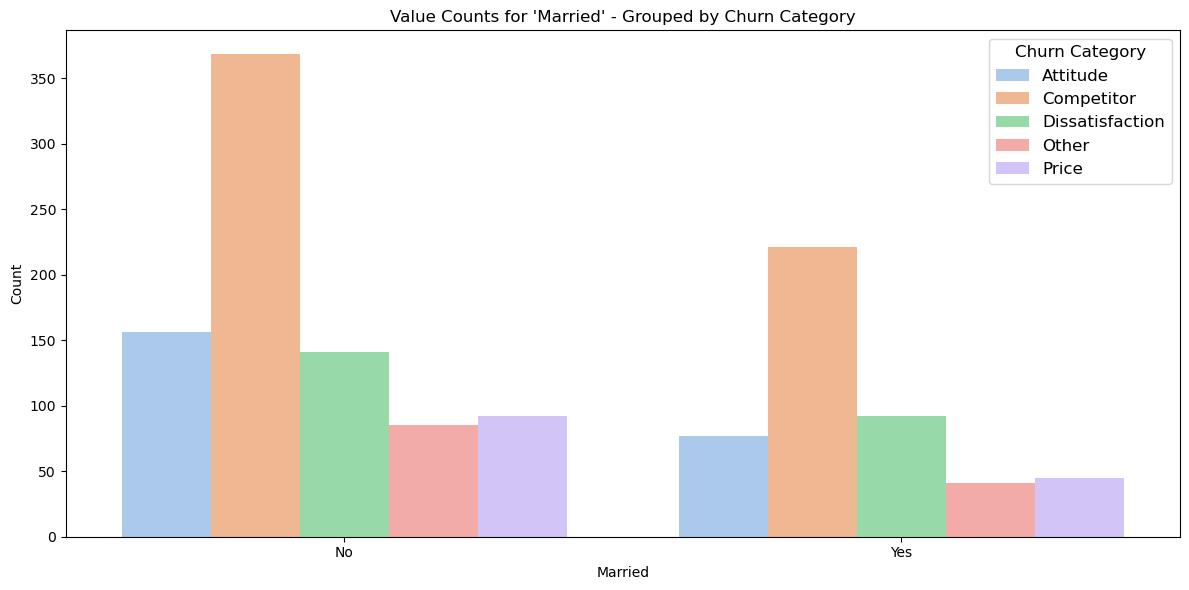

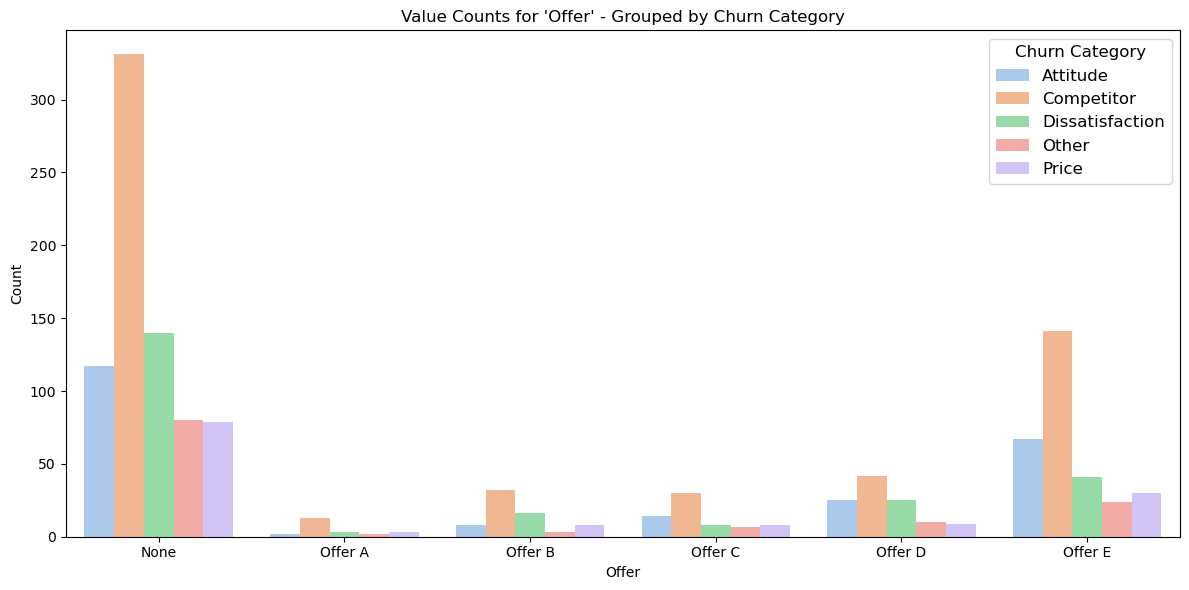

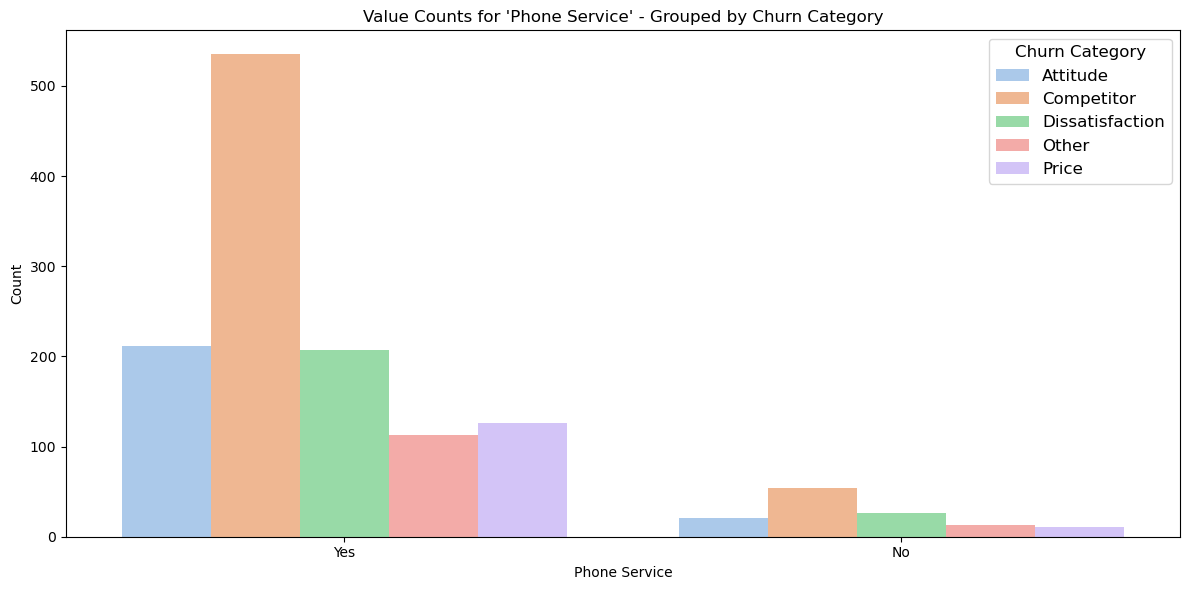

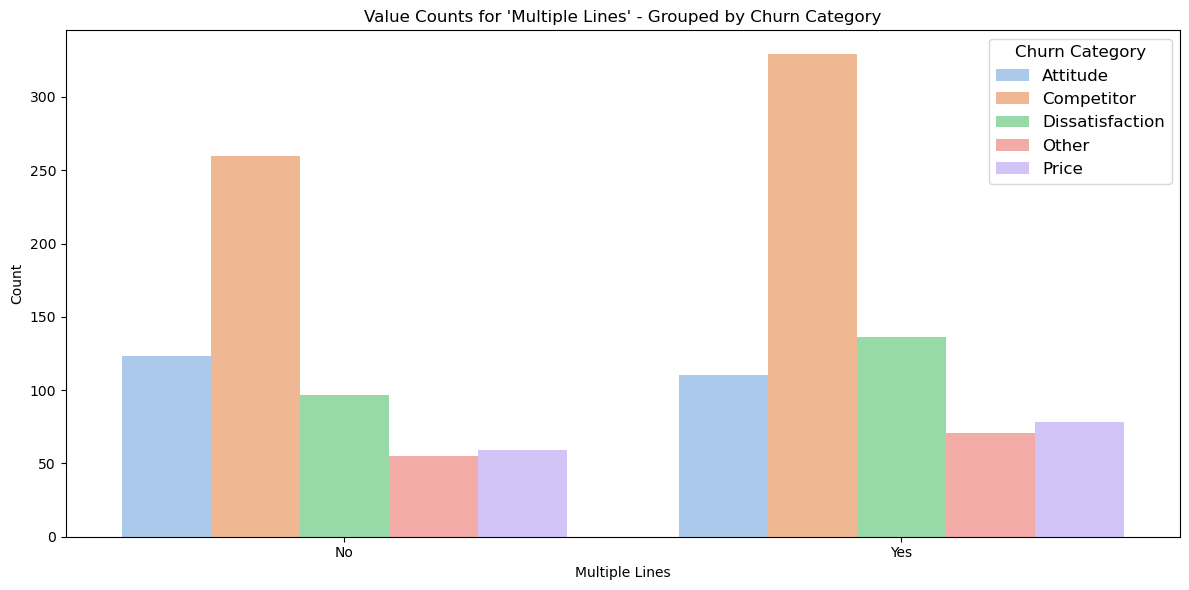

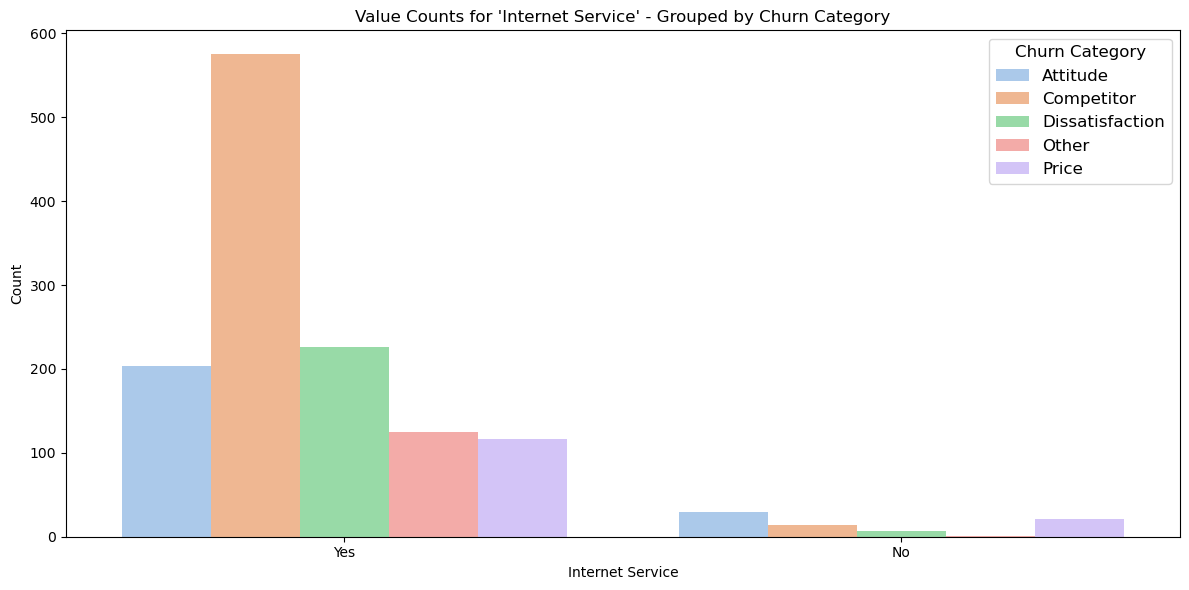

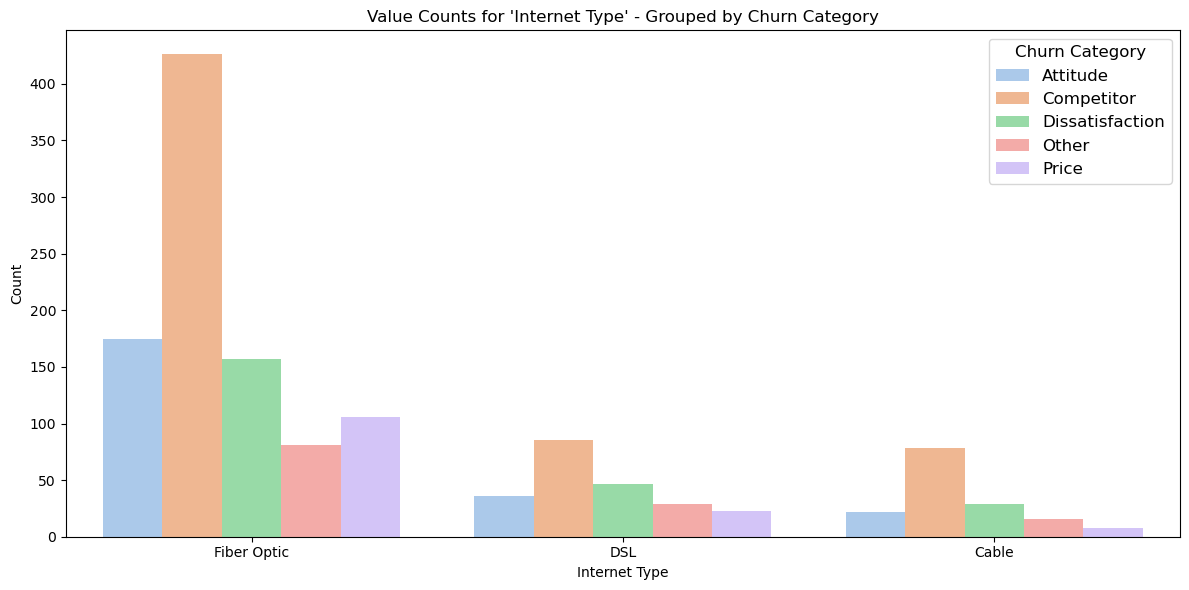

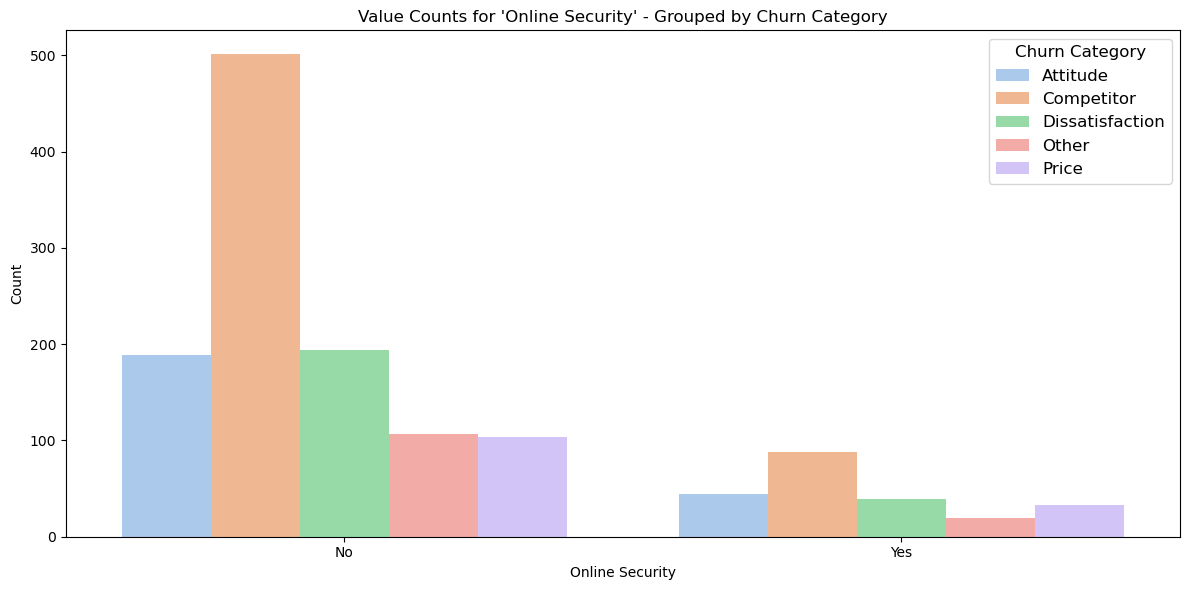

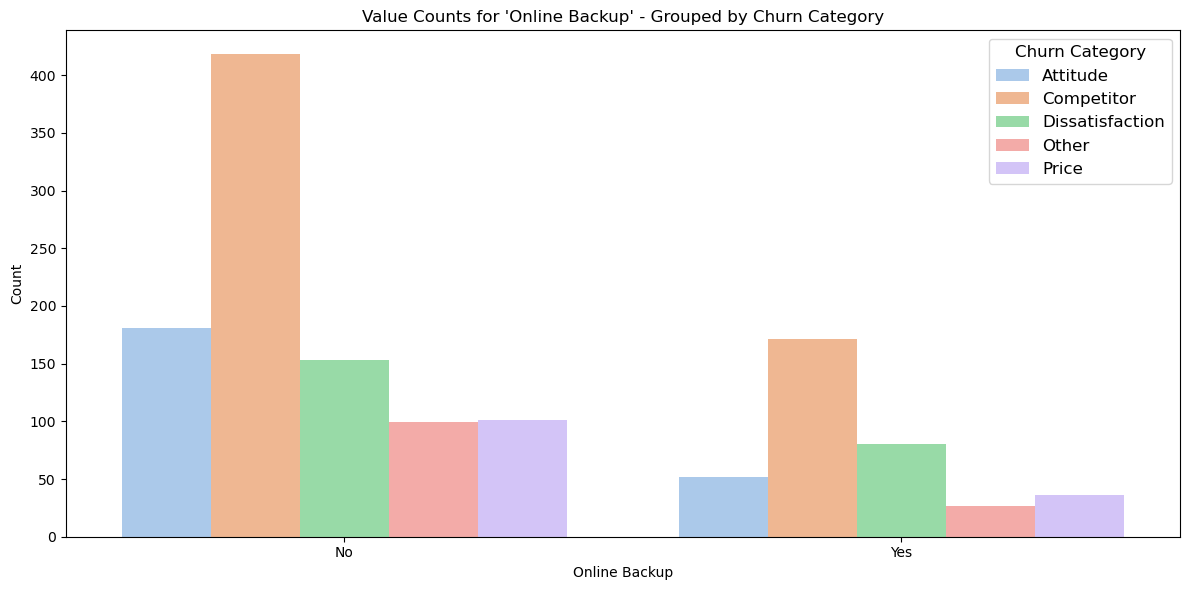

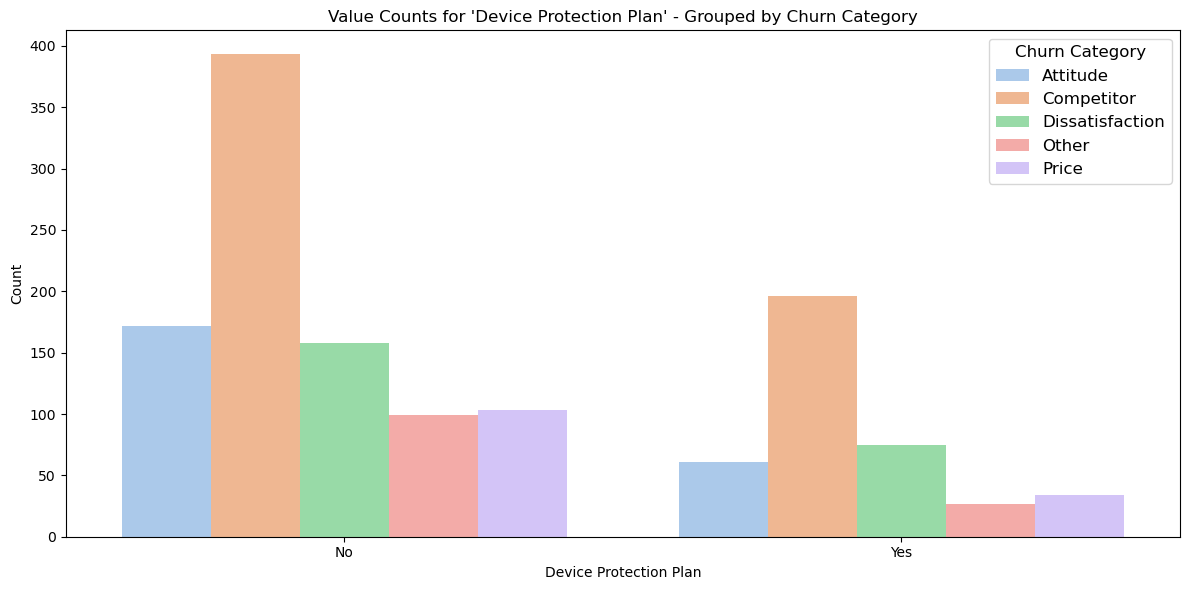

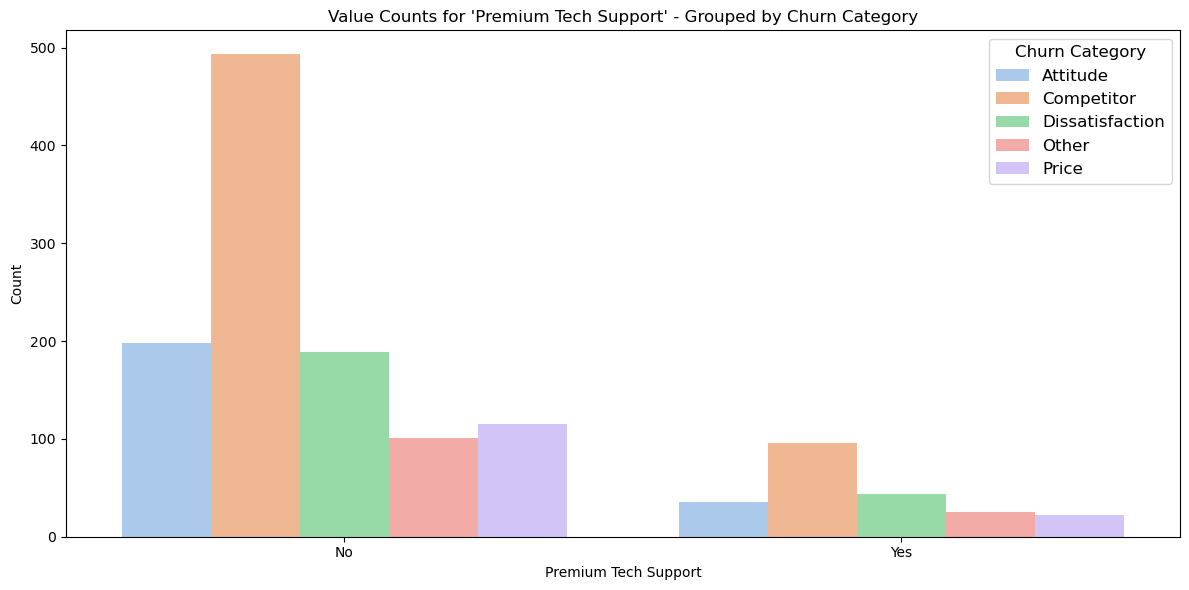

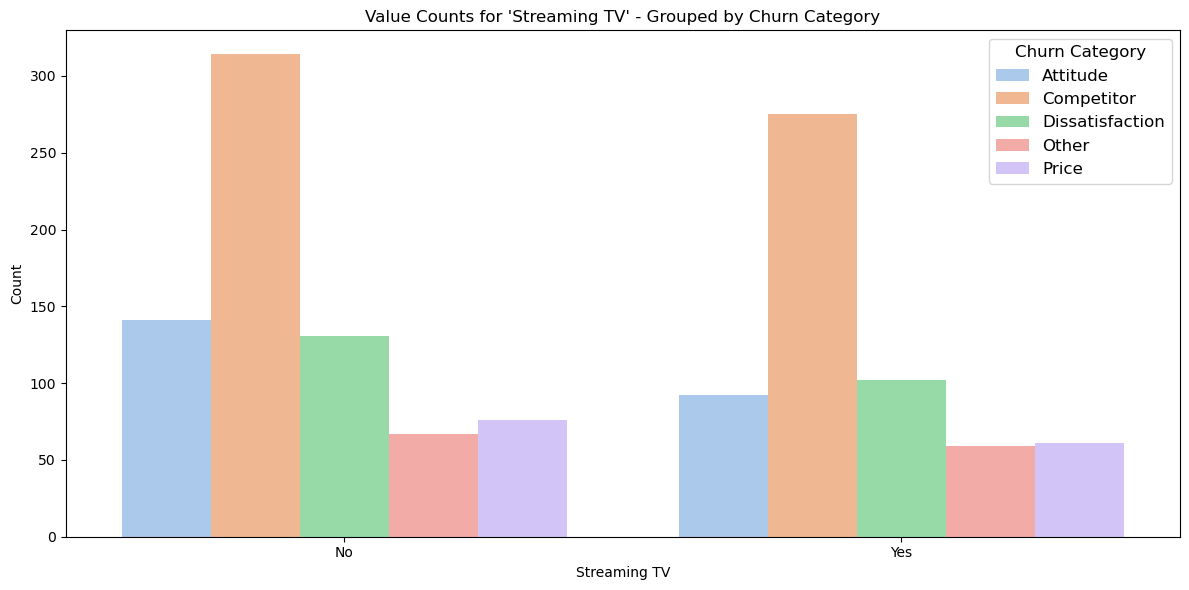

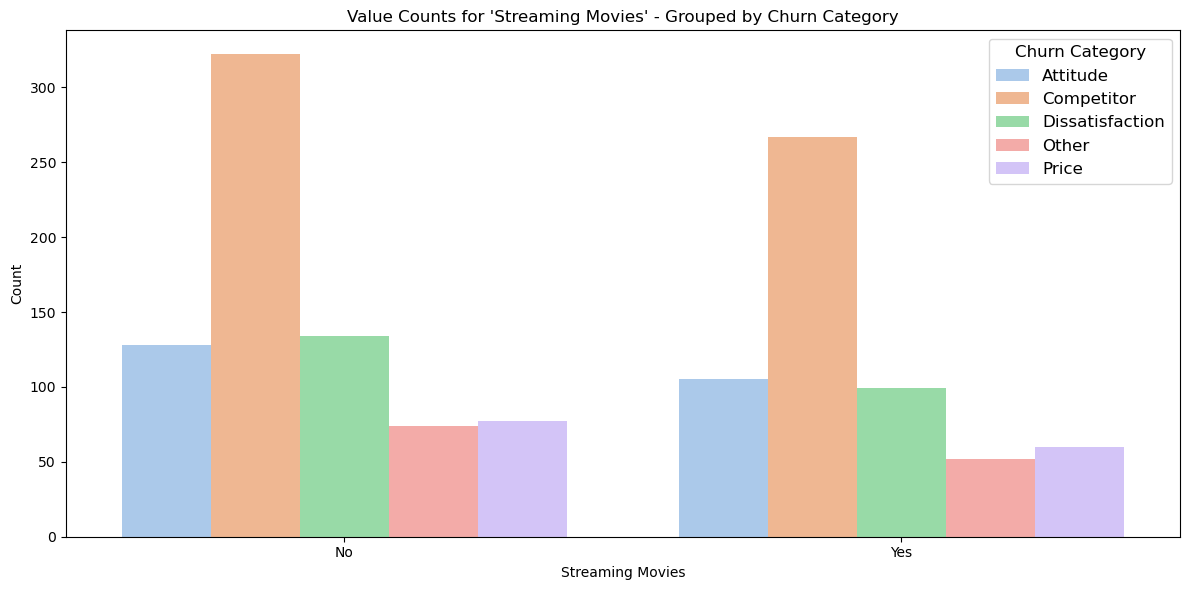

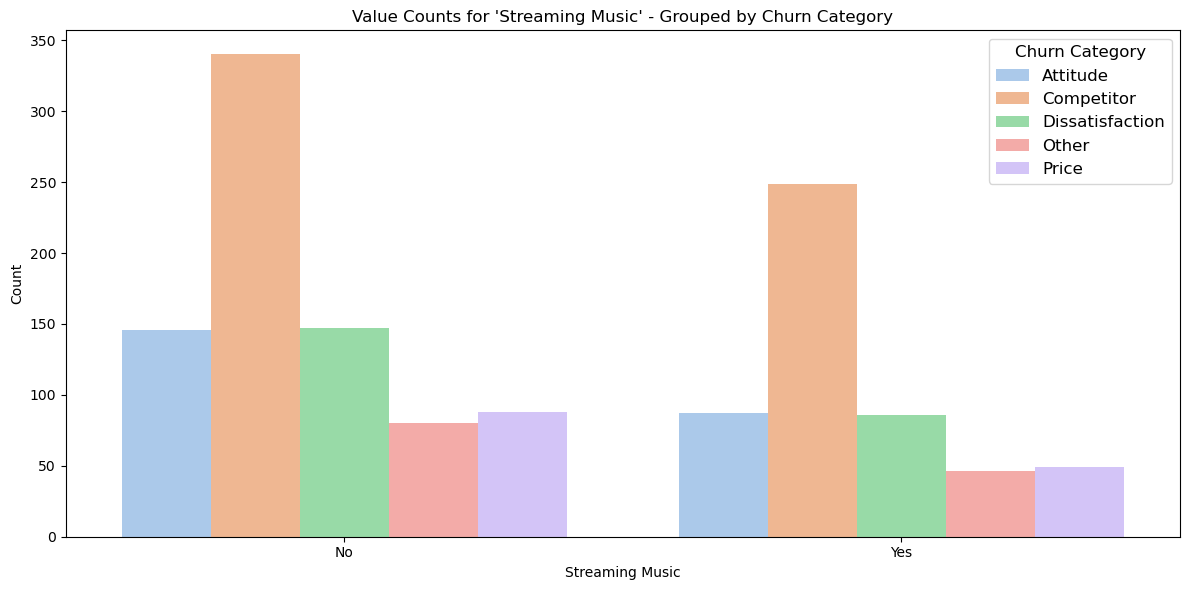

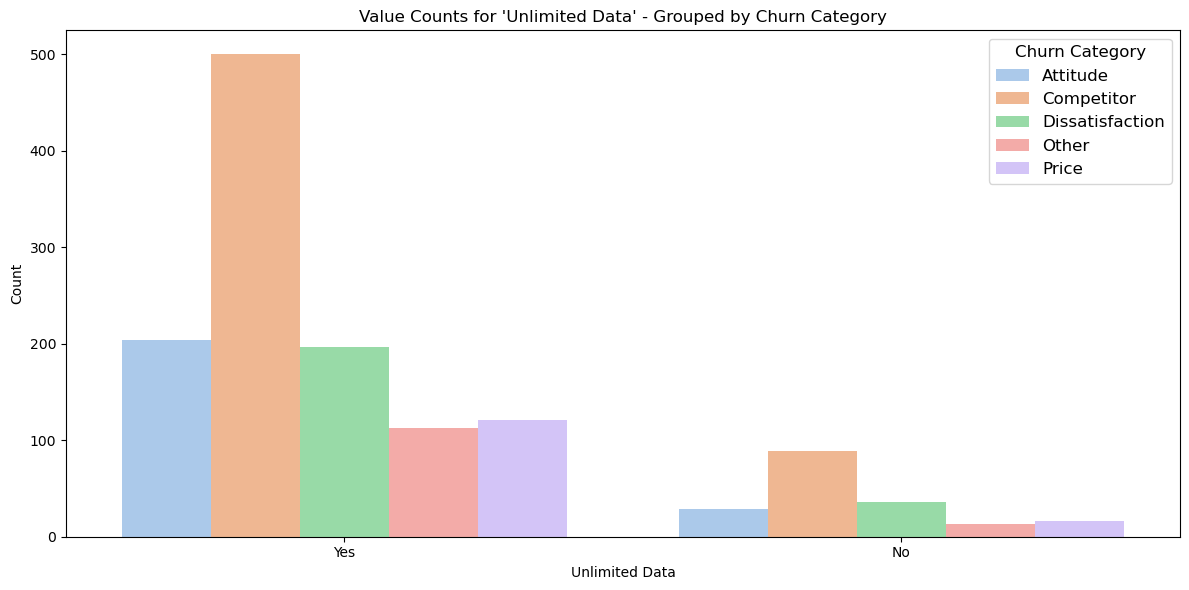

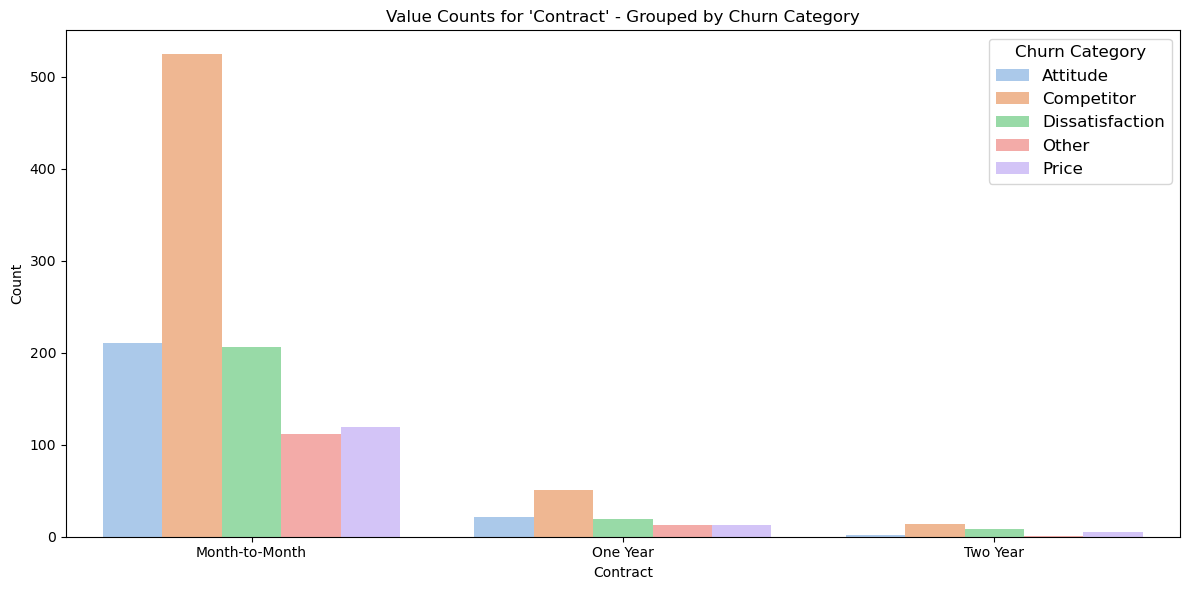

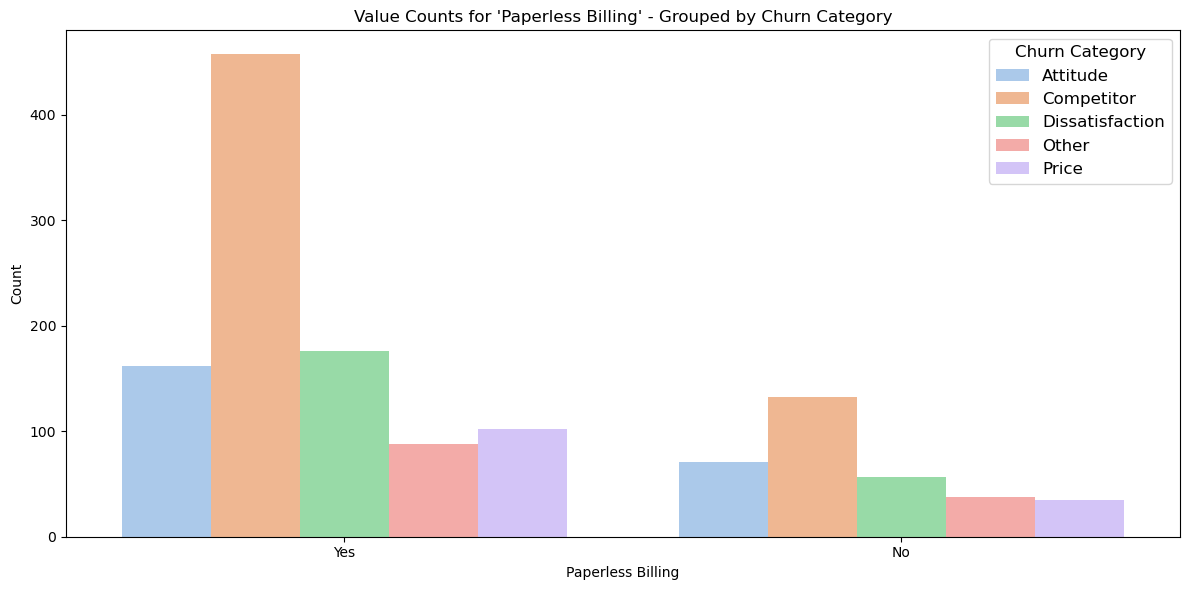

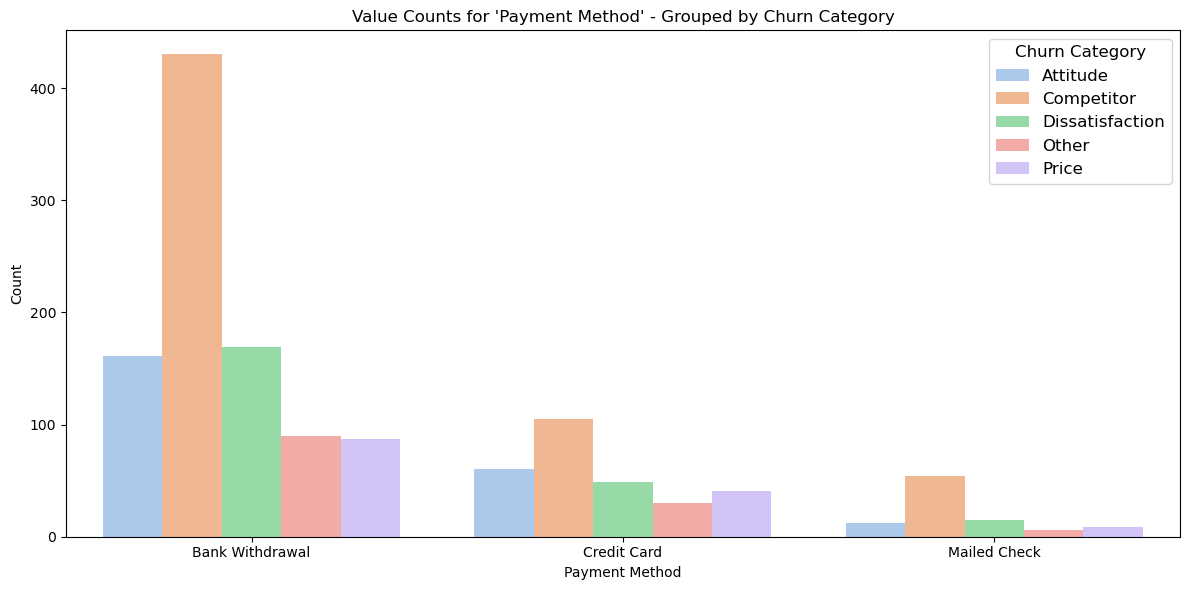

In [24]:
# Group by 'Churn Category' and each categorical column, and get value counts for each category
for col in cat_cols_res:
    plt.figure(figsize=(12, 6))
    plt.title(f"Value Counts for '{col}' - Grouped by Churn Category")

    # Group the data by 'Churn Category' and the current column, and get value counts for each category
    group_counts = df_reason.groupby(['Churn Category', col]).size().unstack()

    # Sort the values in each category based on their counts in descending order
    group_counts_sorted = group_counts.apply(lambda x: x.sort_values(ascending=False), axis=1)

    # Plot the grouped bar chart
    sns.barplot(data=group_counts_sorted.reset_index().melt(id_vars='Churn Category', value_name='Count'),
                x=col, y='Count', hue='Churn Category', palette='pastel')

    # Set labels and legend
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Churn Category', title_fontsize='large', fontsize='large')

    plt.tight_layout()
    plt.show()

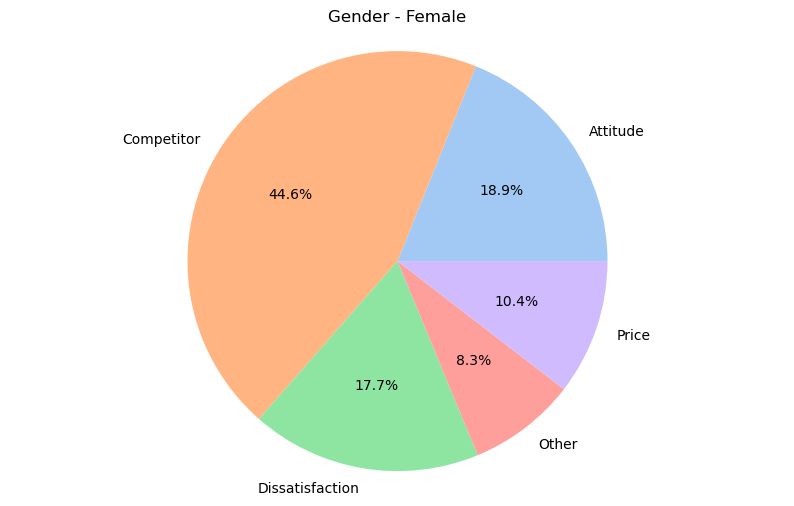

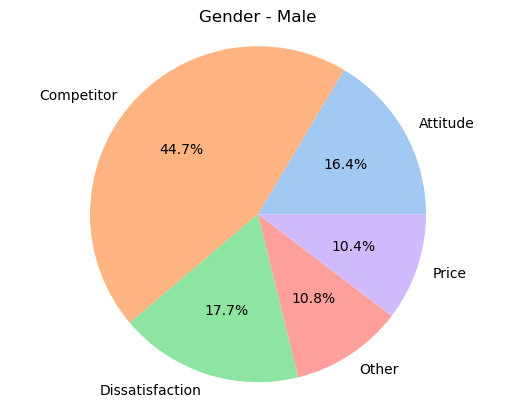

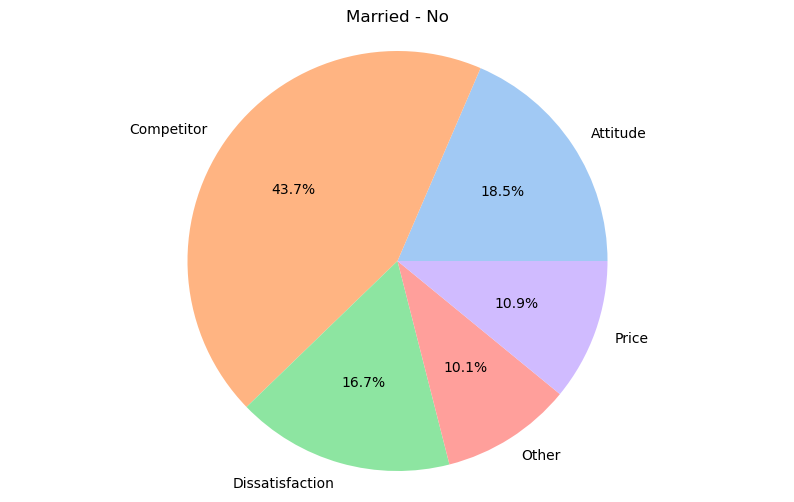

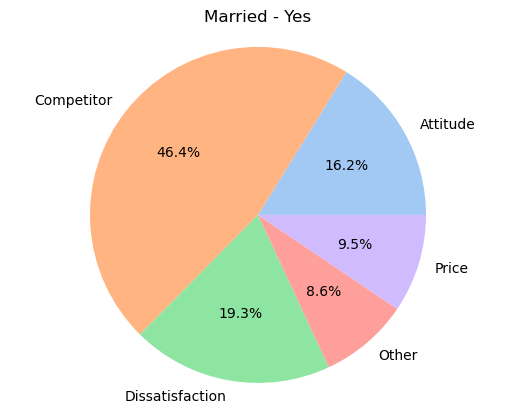

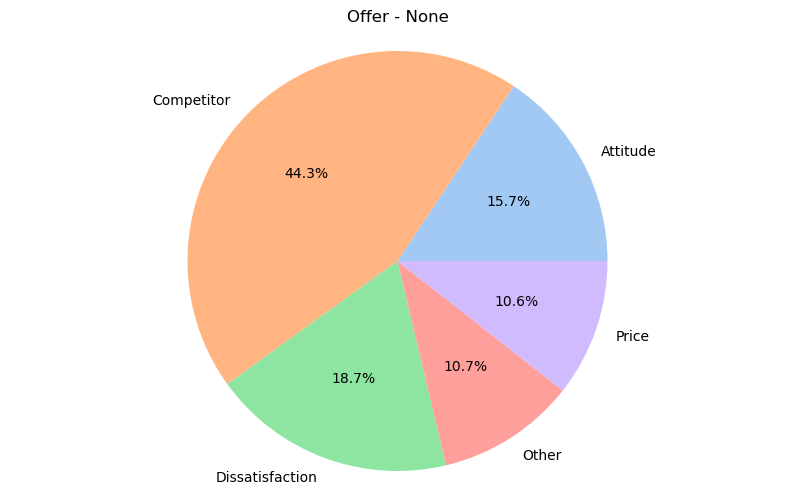

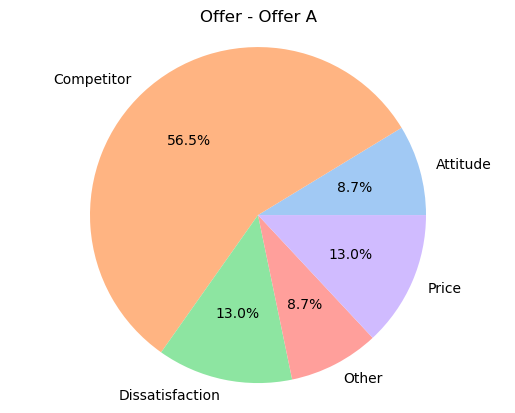

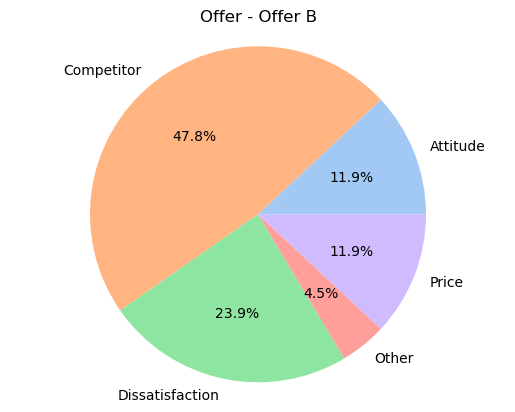

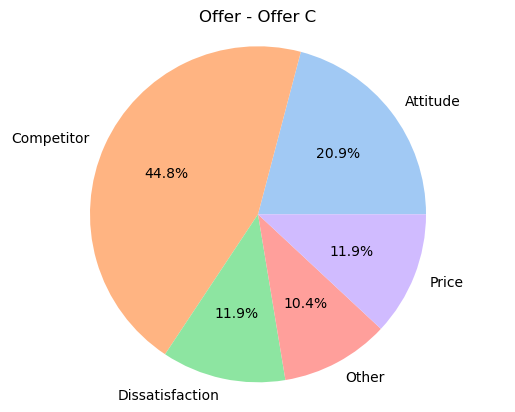

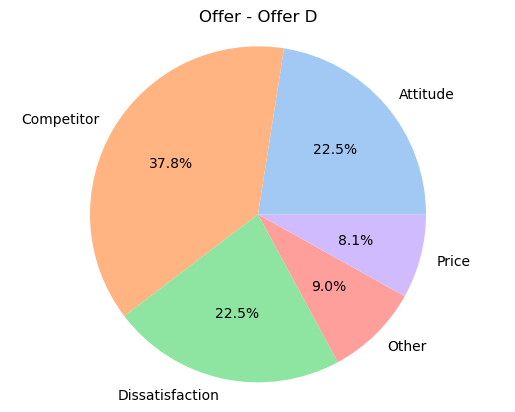

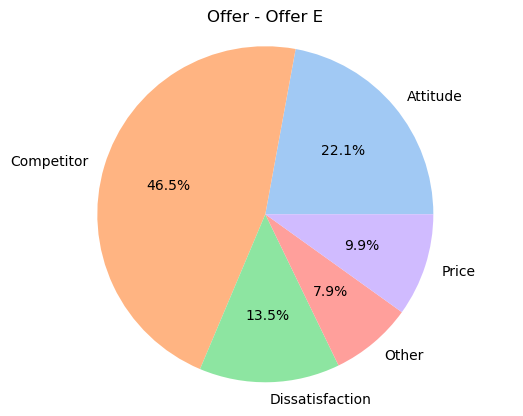

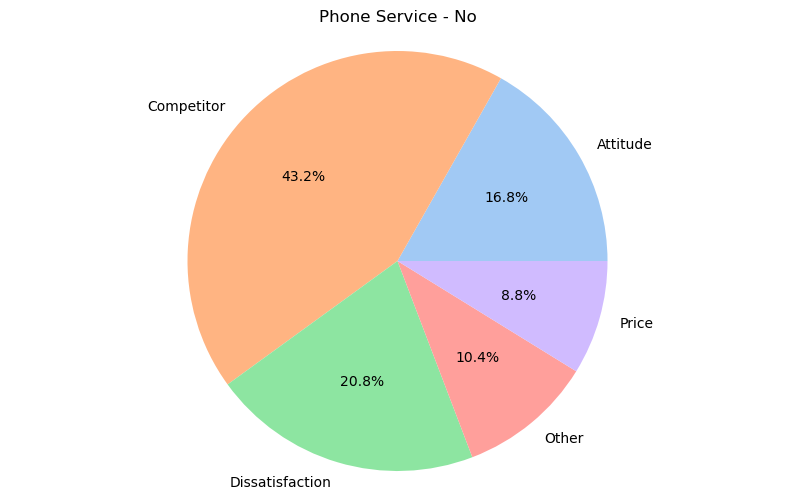

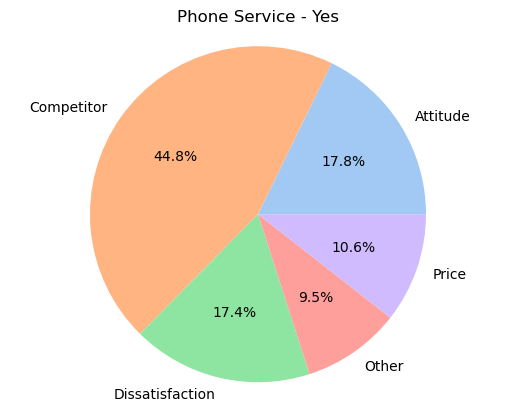

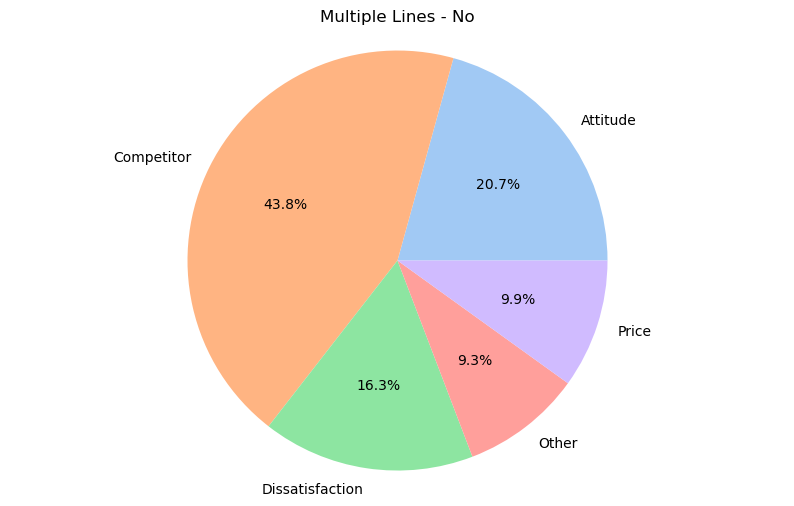

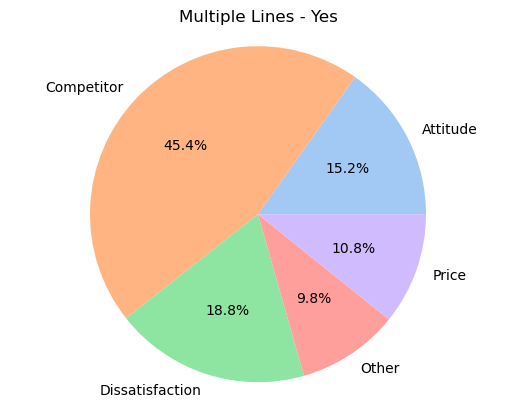

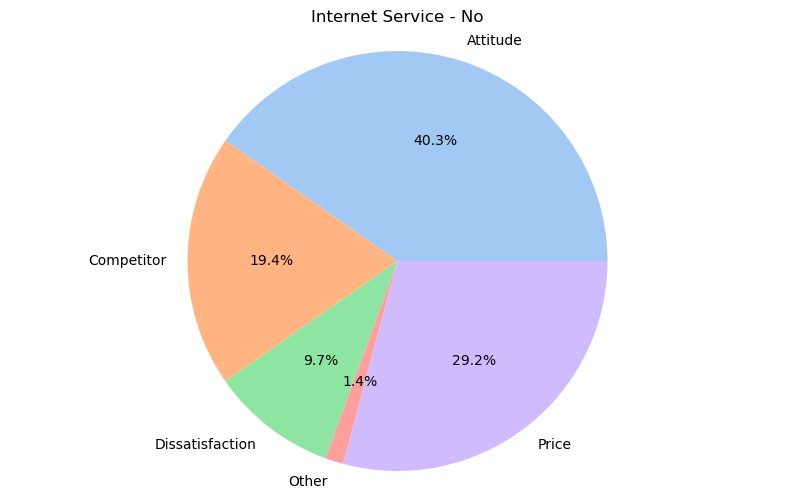

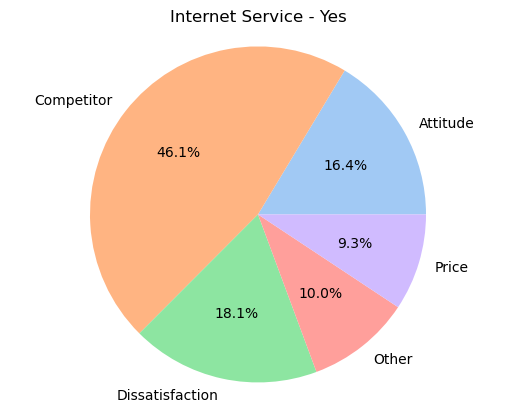

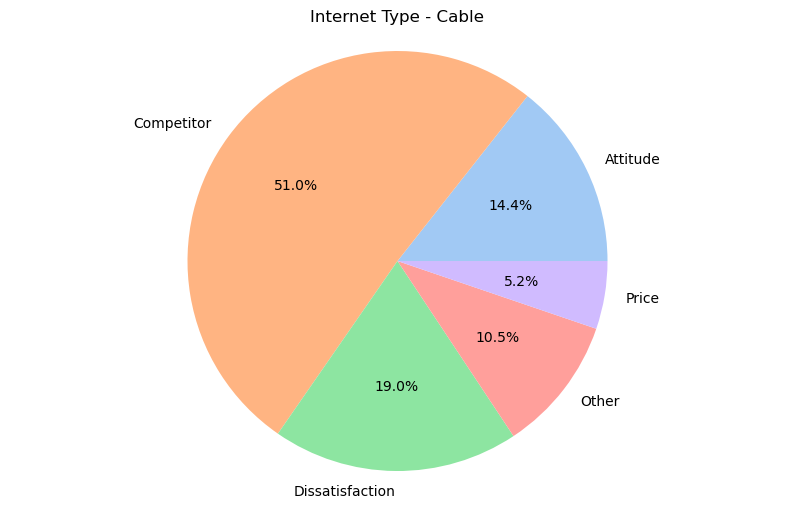

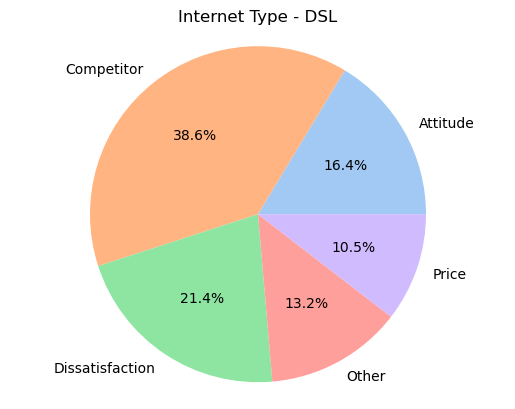

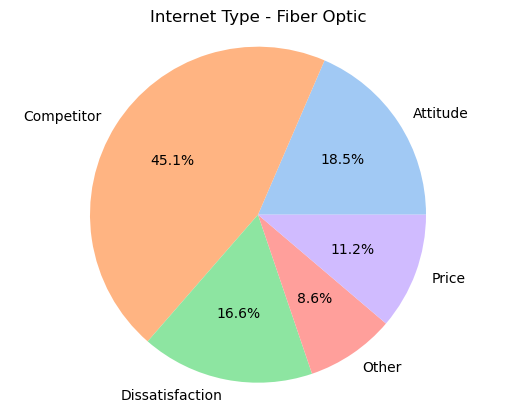

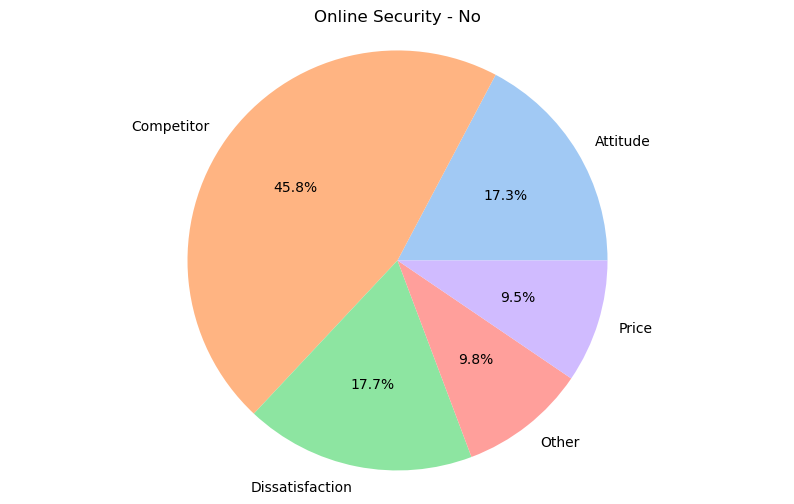

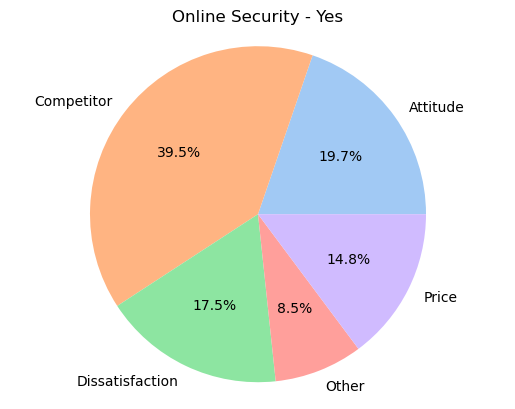

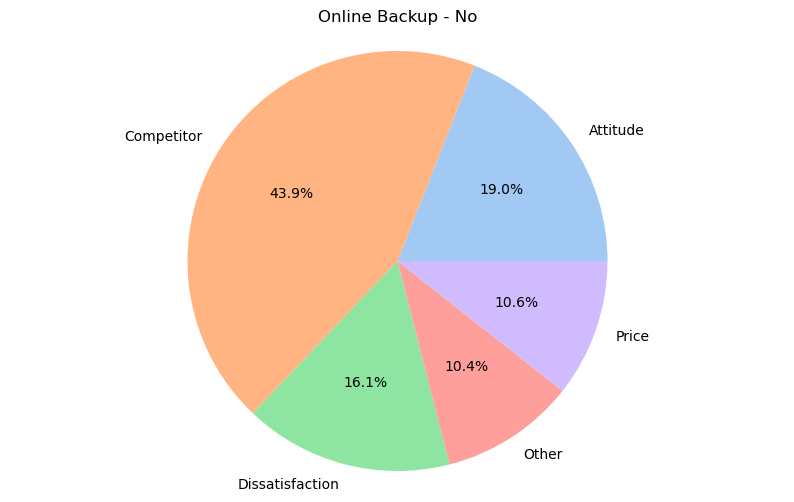

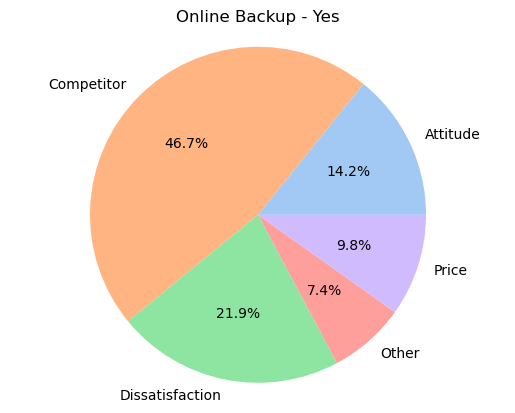

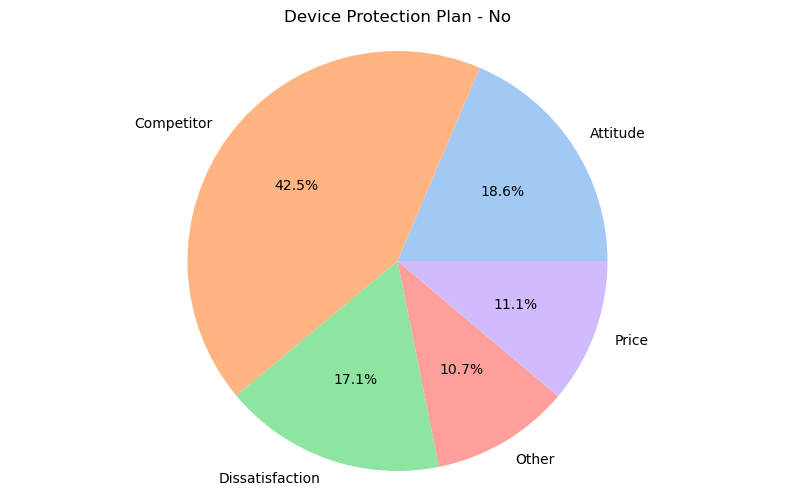

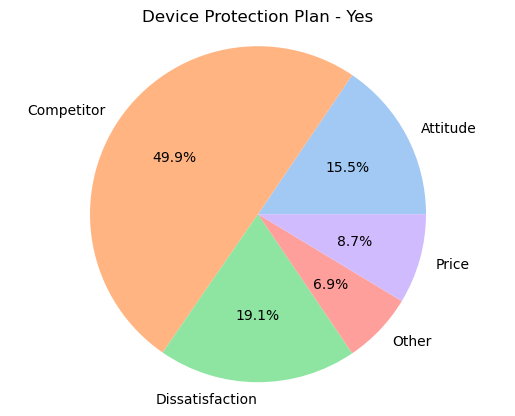

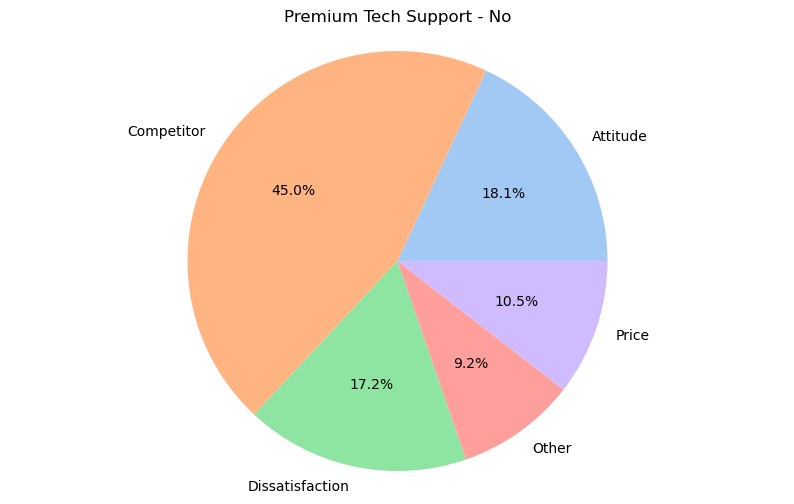

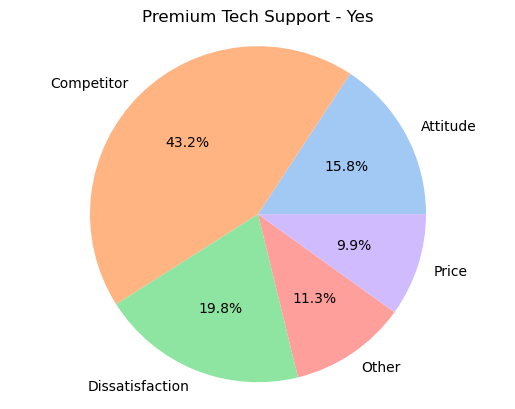

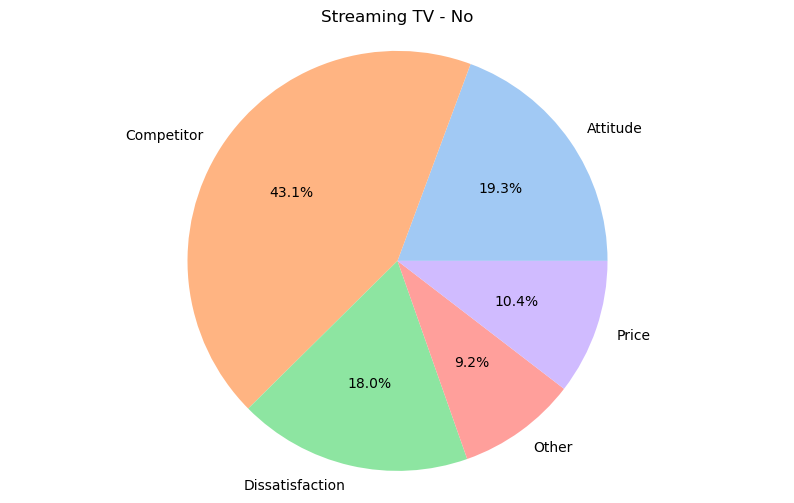

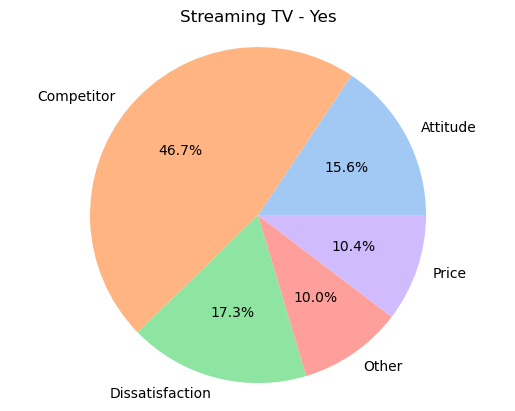

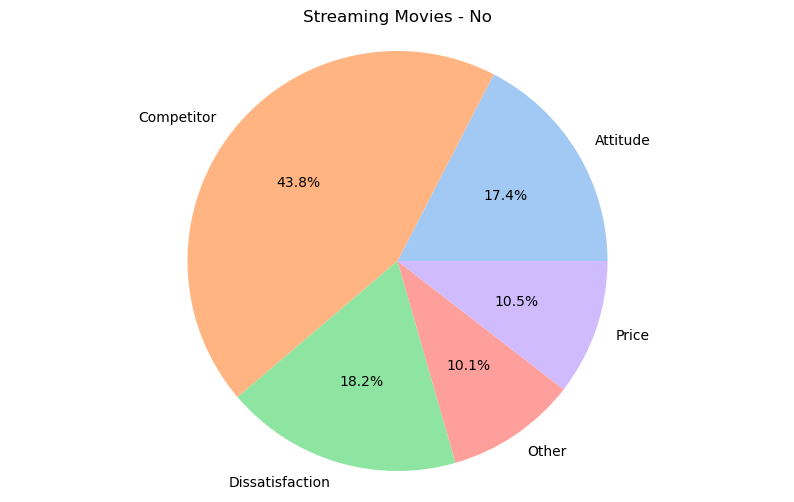

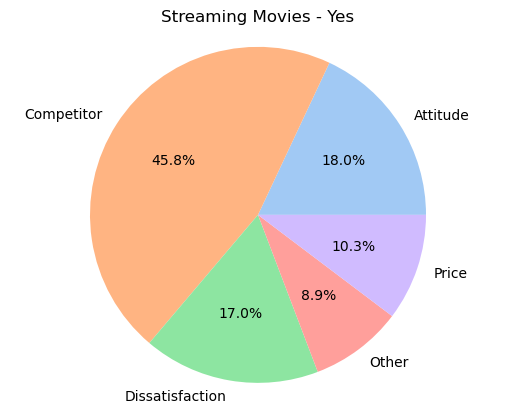

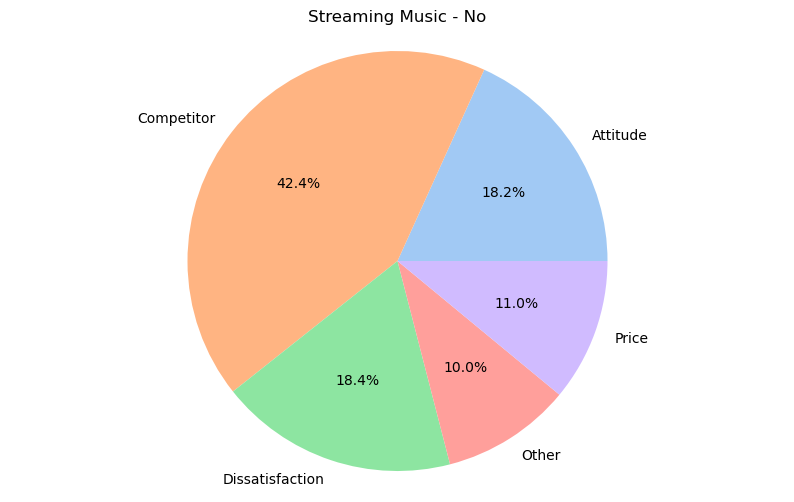

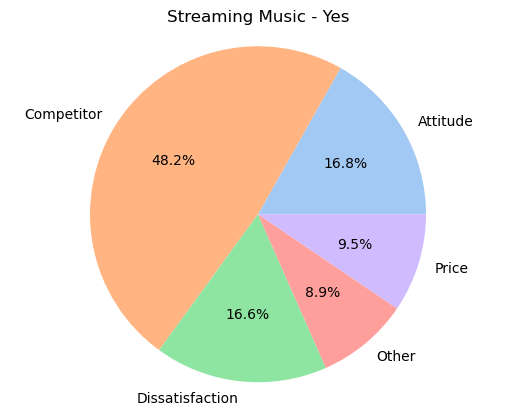

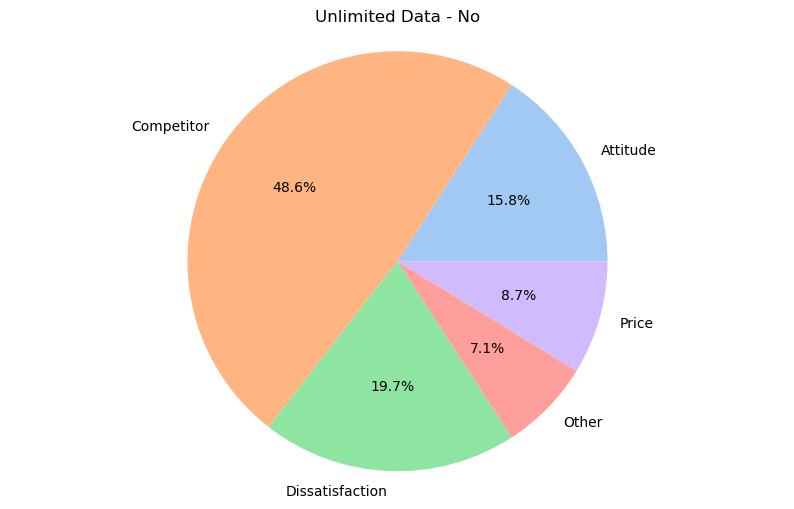

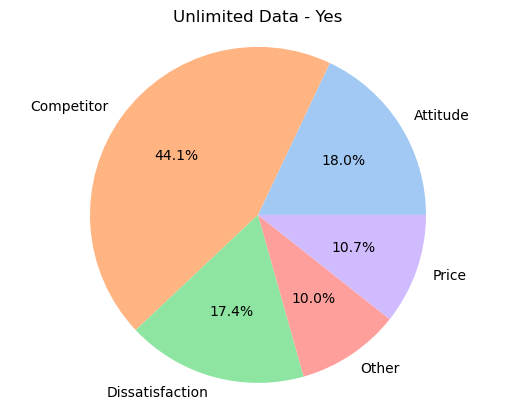

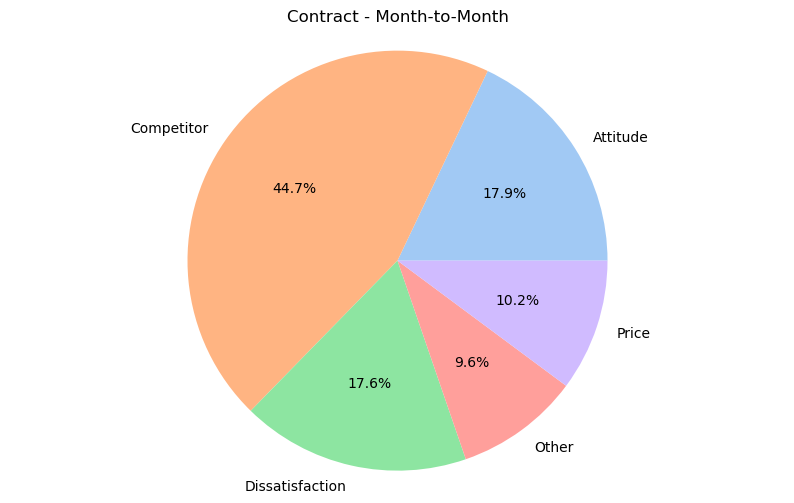

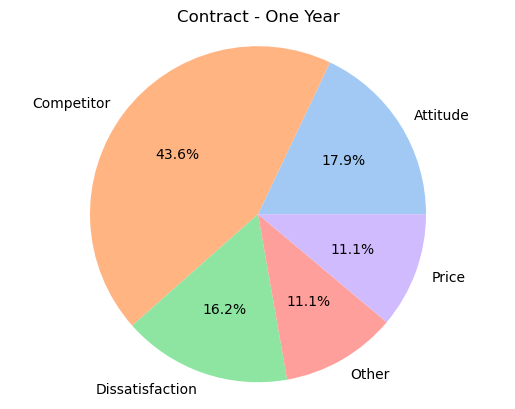

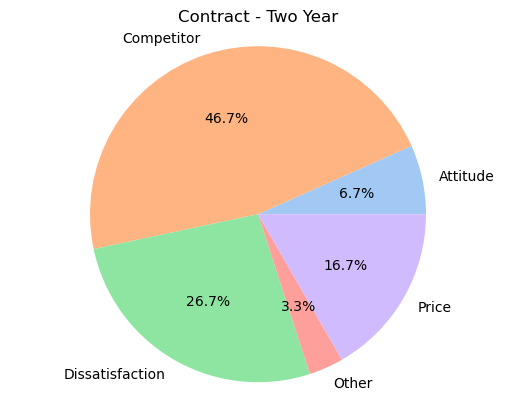

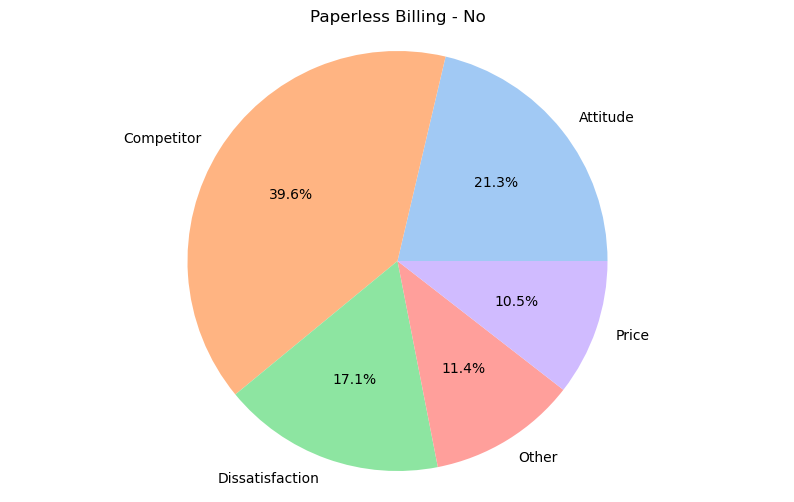

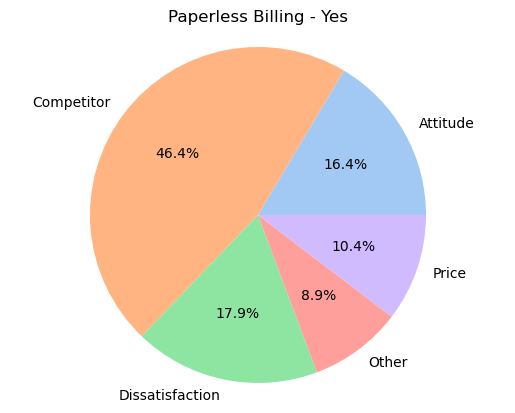

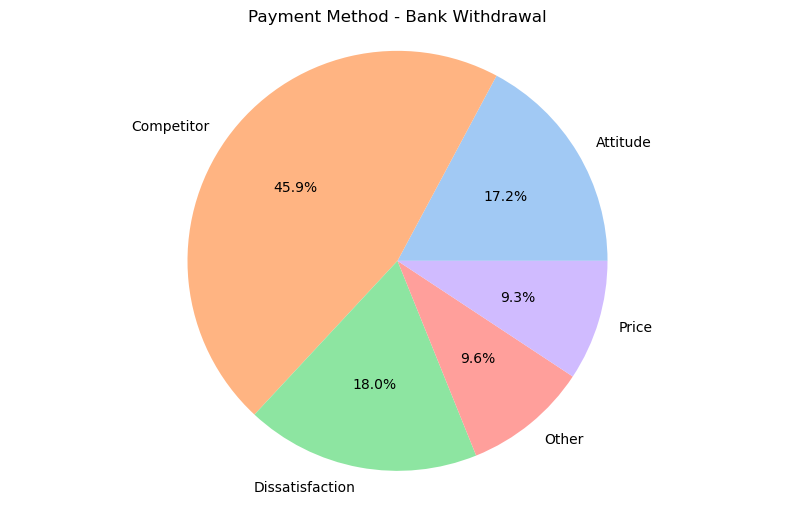

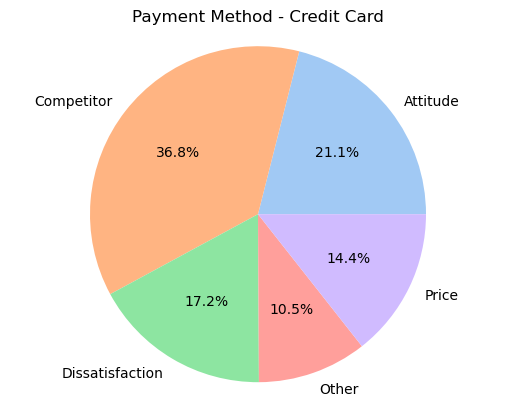

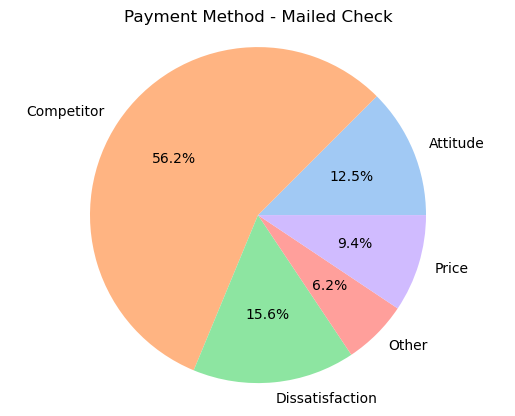

In [25]:
# Group by each categorical column and 'Churn Category', and get value counts for each category
for col in cat_cols_res:
    plt.figure(figsize=(10, 6))
    plt.title(f"Pie Chart for '{col}' - Comparison of Churn Categories")

    # Group the data by 'Churn Category' and the current column, and get value counts for each category
    group_counts = df_reason.groupby([col, 'Churn Category']).size().unstack()

    # Get the list of 'Churn Category' values
    churn_categories = group_counts.columns

    # Iterate through each category and plot the pie chart
    for category in group_counts.index:
        category_counts = group_counts.loc[category]
        plt.pie(category_counts, labels=churn_categories, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
        plt.title(f"{col} - {category}")
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.show()


In [26]:
#TODO: Apply dimensionality reduction to churn reason analysis. Currently the features are really noisy
#TODO: Redo EDA to check for Distribution, central tendancy and dispersions.